<a href="https://colab.research.google.com/github/Ruchika-01/my_projects/blob/main/Digit_Generation_with_Autoregressive_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask_type, input_degrees=None, output_degrees=None):
        super().__init__(in_features, out_features)
        self.mask_type = mask_type
        self.register_buffer('mask', torch.ones(out_features, in_features))
        self.input_degrees = input_degrees
        self.output_degrees = output_degrees
        self.build_mask()

    def build_mask(self):
        if self.input_degrees is not None and self.output_degrees is not None:
            if self.mask_type == 'input' or self.mask_type == 'hidden':
                mask = self.output_degrees[:, None] >= self.input_degrees[None, :]
            elif self.mask_type == 'output':
                mask = self.output_degrees[:, None] > self.input_degrees[None, :]
            self.mask.data.copy_(mask.float())

    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)


In [ ]:
class MADE(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 512]):
        super().__init__()
        self.input_size = input_size

        # Assign random degrees for autoregressive property
        self.m = {}
        self.m[0] = torch.arange(input_size)
        self.m[1] = torch.randint(1, input_size, (hidden_sizes[0],))
        self.m[2] = torch.randint(1, input_size, (hidden_sizes[1],))
        self.m[3] = self.m[0]

        self.fc1 = MaskedLinear(input_size, hidden_sizes[0], mask_type='input',
                                input_degrees=self.m[0], output_degrees=self.m[1])
        self.fc2 = MaskedLinear(hidden_sizes[0], hidden_sizes[1], mask_type='hidden',
                                input_degrees=self.m[1], output_degrees=self.m[2])
        self.fc3 = MaskedLinear(hidden_sizes[1], input_size, mask_type='output',
                                input_degrees=self.m[2], output_degrees=self.m[3])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 60.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.80MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.12MB/s]


In [ ]:
def reconstruct_and_plot(model, data_loader, n=8):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.view(-1, 784).to(next(model.parameters()).device)
        logits = model(x)
        x_recon = torch.sigmoid(logits)

        x = x.view(-1, 28, 28).cpu()
        x_recon = x_recon.view(-1, 28, 28).cpu()

        fig, axs = plt.subplots(2, n, figsize=(n * 1.5, 3))
        for i in range(n):
            axs[0, i].imshow(x[i], cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(x_recon[i], cmap='gray')
            axs[1, i].axis('off')
        axs[0, 0].set_ylabel('Original')
        axs[1, 0].set_ylabel('Generated')
        plt.tight_layout()
        plt.show()

Epoch 1, Loss: 0.2754


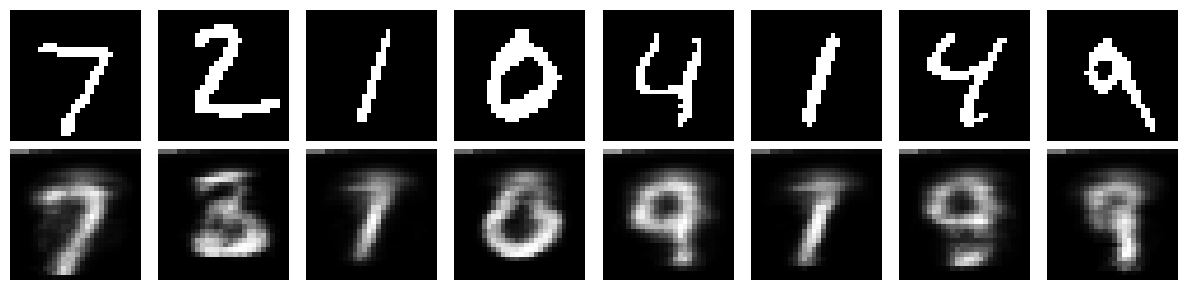

Epoch 2, Loss: 0.1769


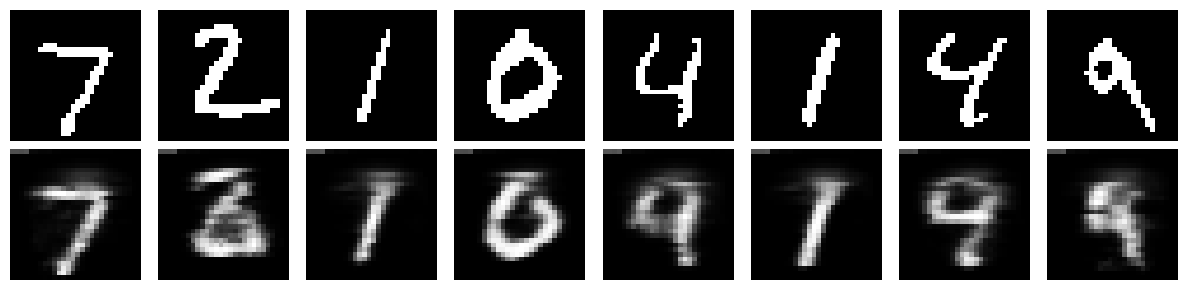

Epoch 3, Loss: 0.1510


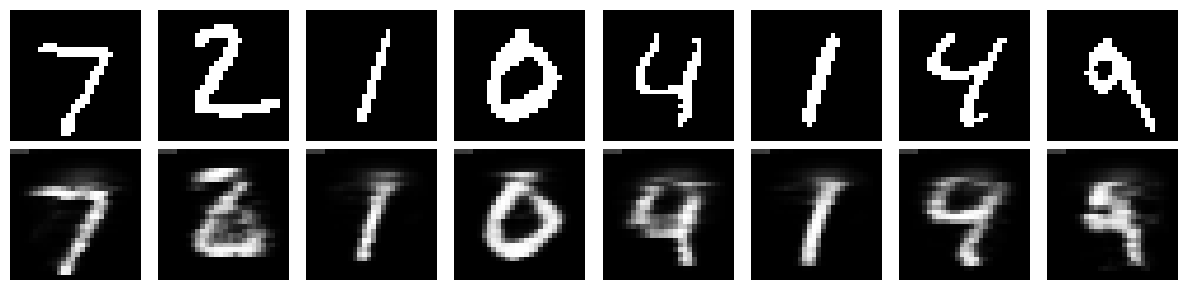

Epoch 4, Loss: 0.1390


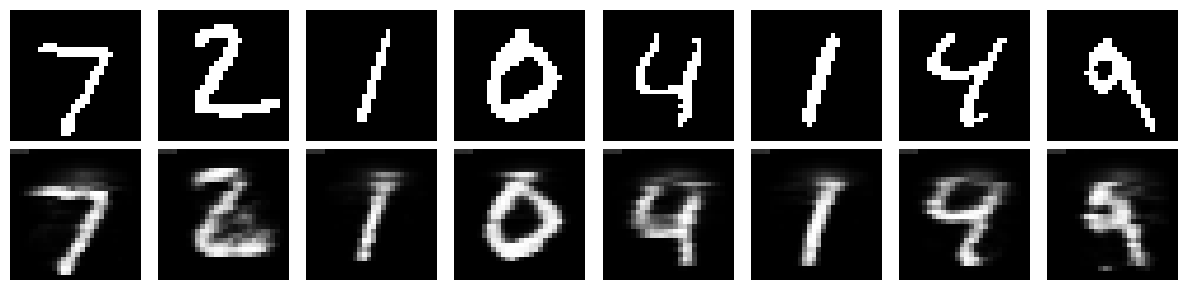

Epoch 5, Loss: 0.1320


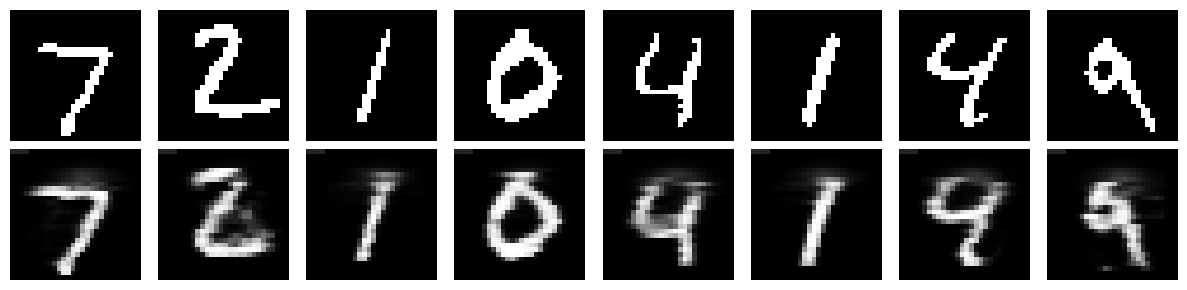

Epoch 6, Loss: 0.1275


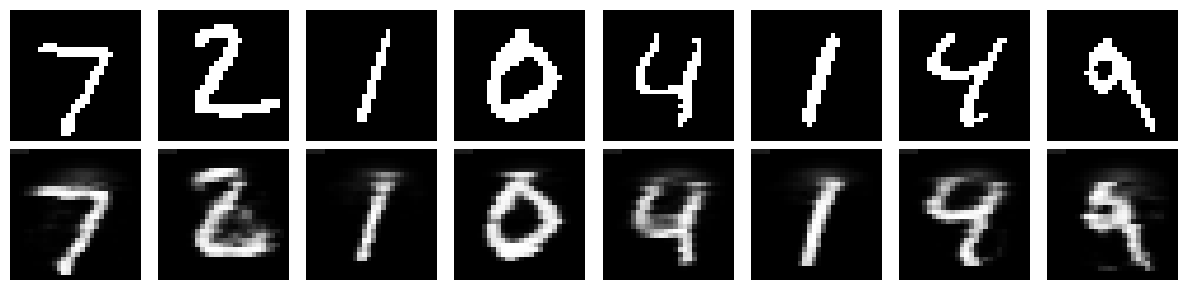

Epoch 7, Loss: 0.1242


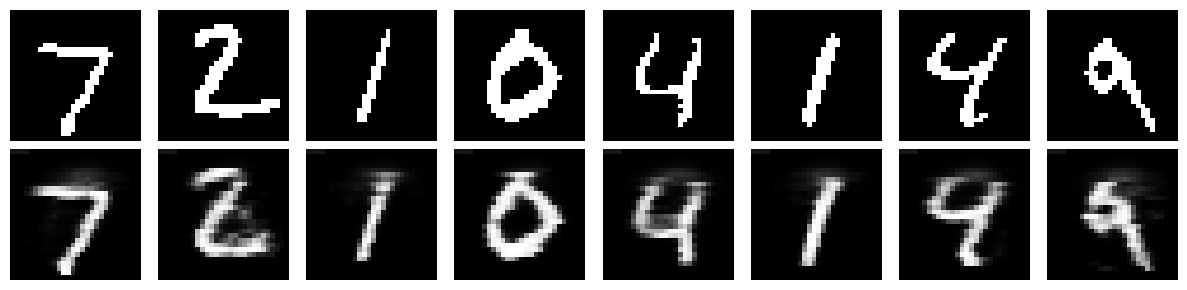

Epoch 8, Loss: 0.1216


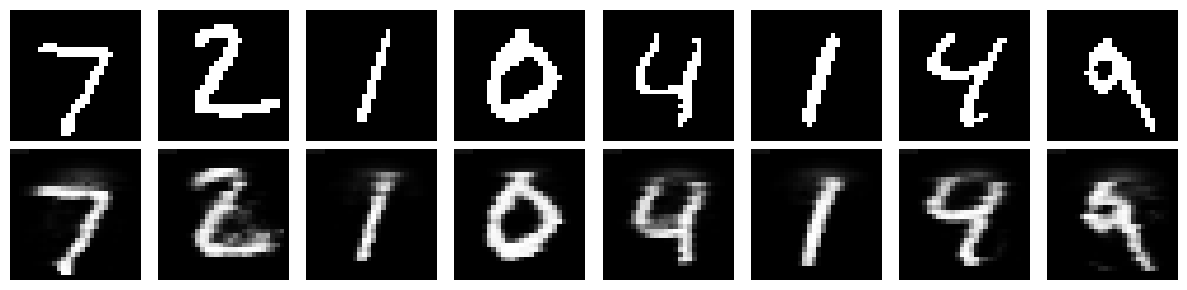

Epoch 9, Loss: 0.1196


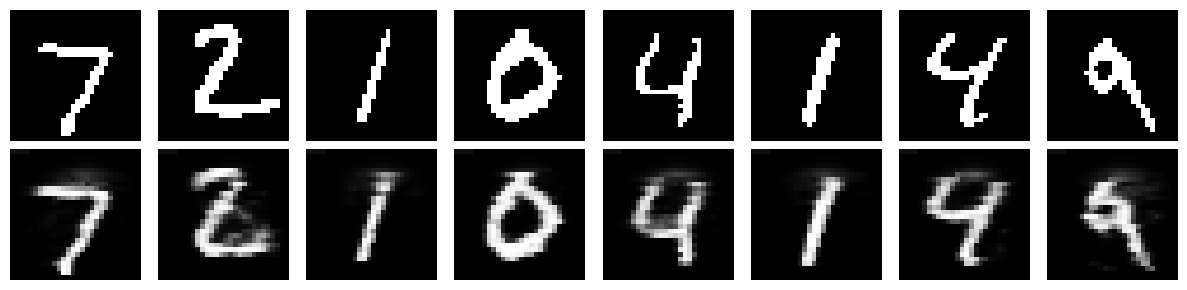

Epoch 10, Loss: 0.1178


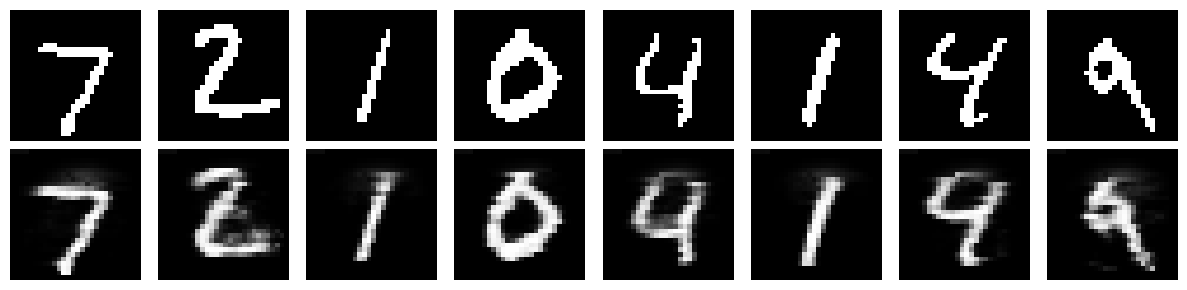

Epoch 11, Loss: 0.1164


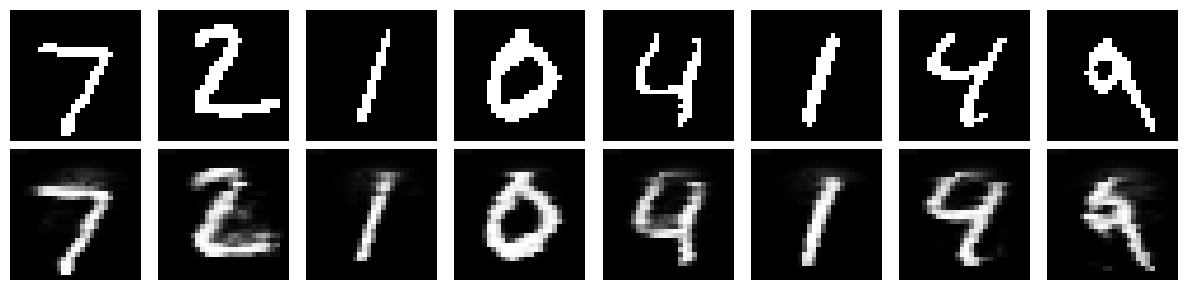

Epoch 12, Loss: 0.1152


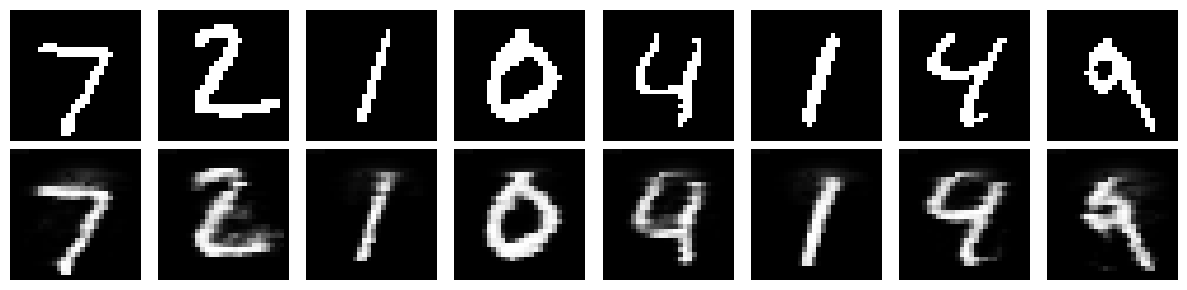

Epoch 13, Loss: 0.1141


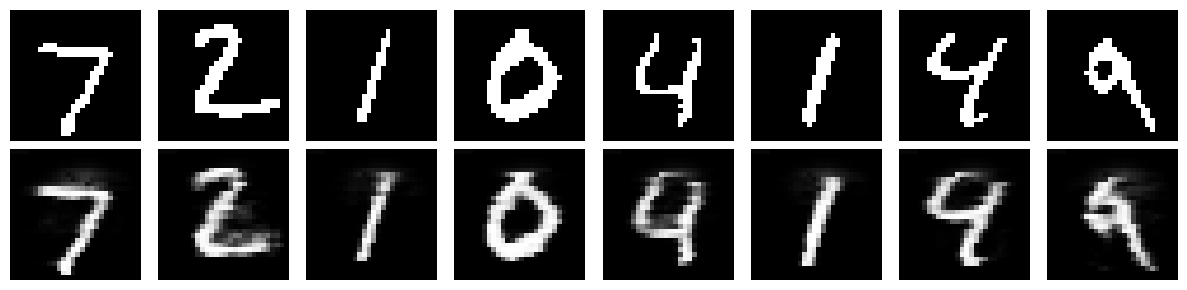

Epoch 14, Loss: 0.1132


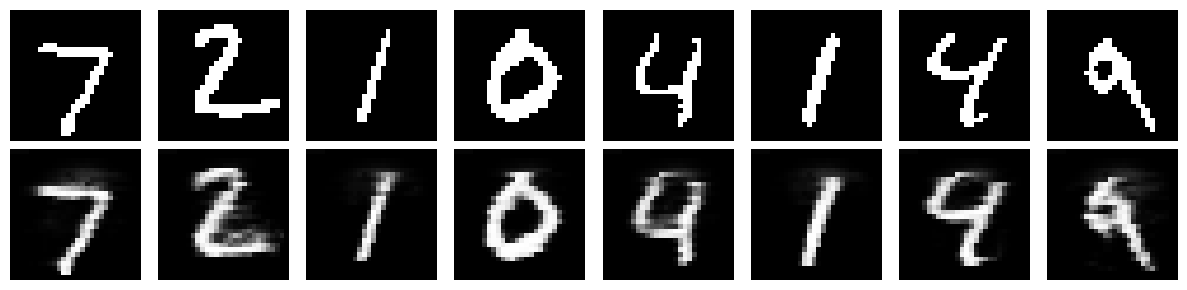

Epoch 15, Loss: 0.1123


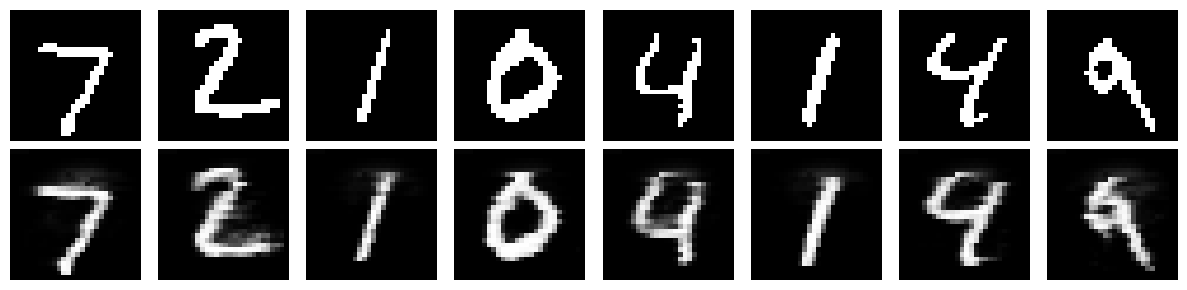

Epoch 16, Loss: 0.1116


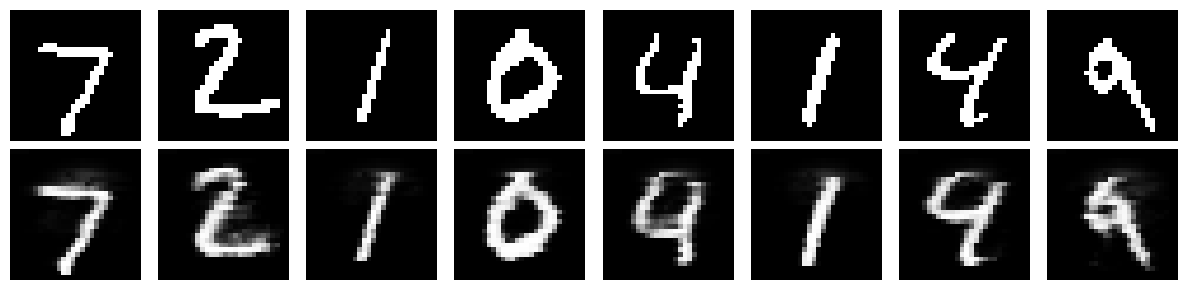

Epoch 17, Loss: 0.1109


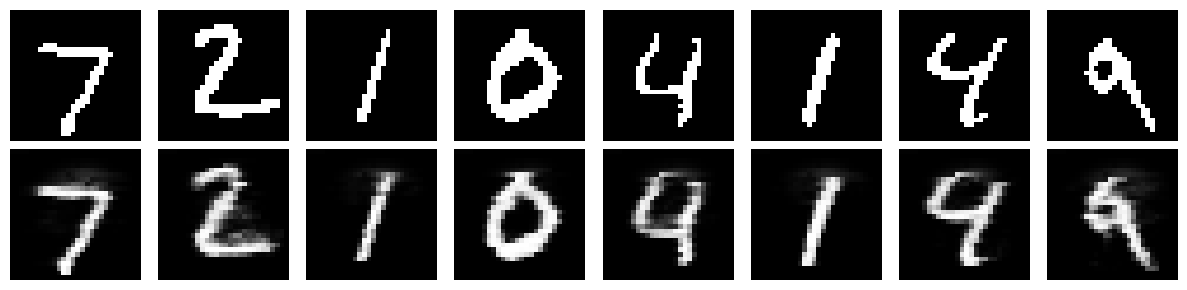

Epoch 18, Loss: 0.1103


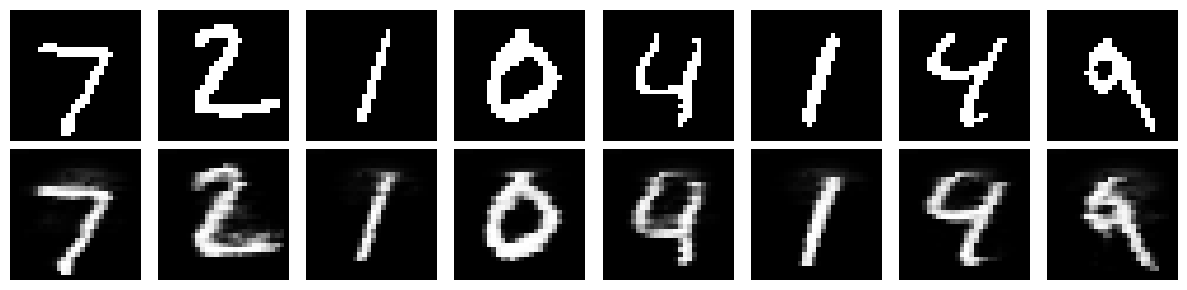

Epoch 19, Loss: 0.1098


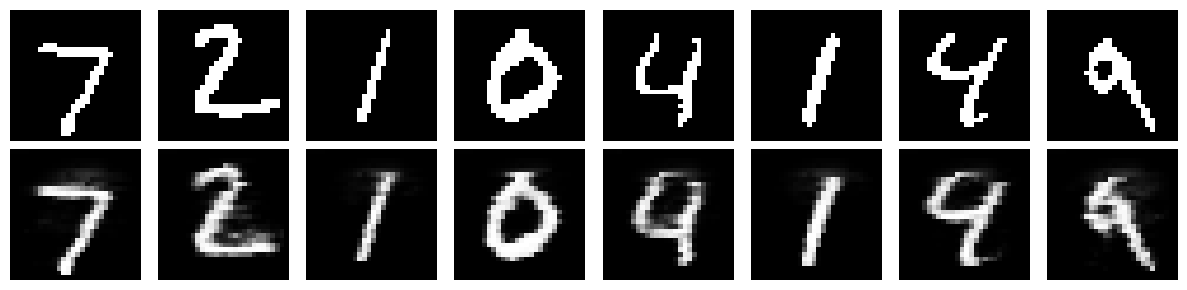

Epoch 20, Loss: 0.1093


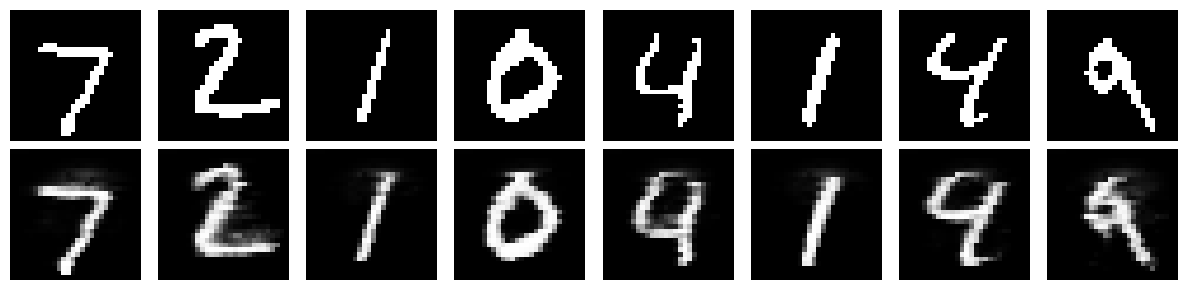

Epoch 21, Loss: 0.1089


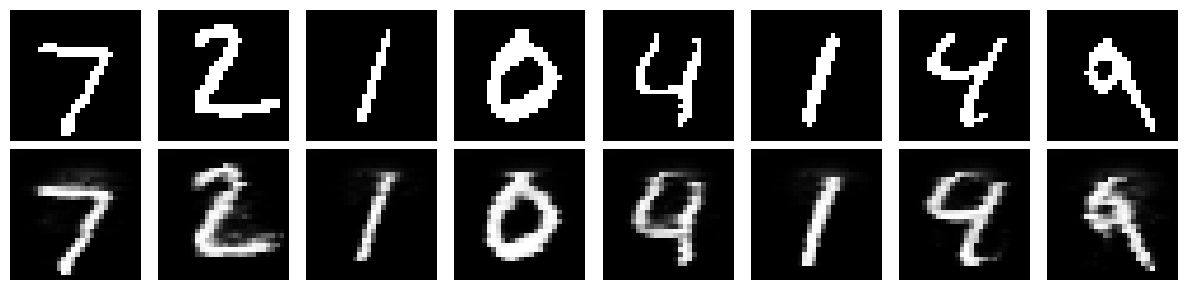

Epoch 22, Loss: 0.1084


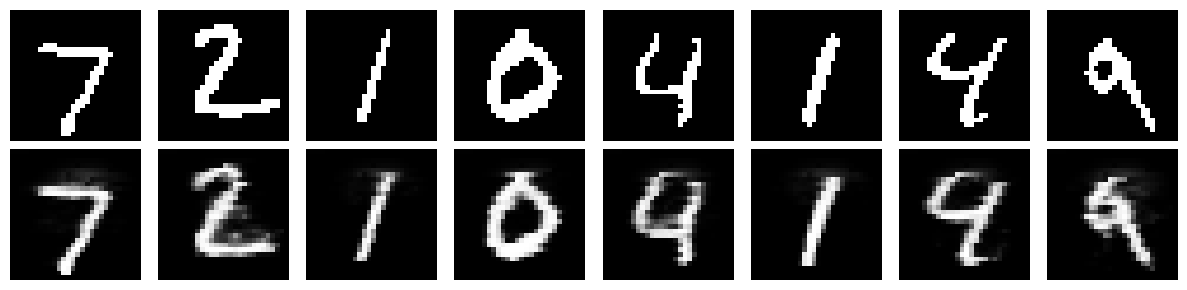

Epoch 23, Loss: 0.1081


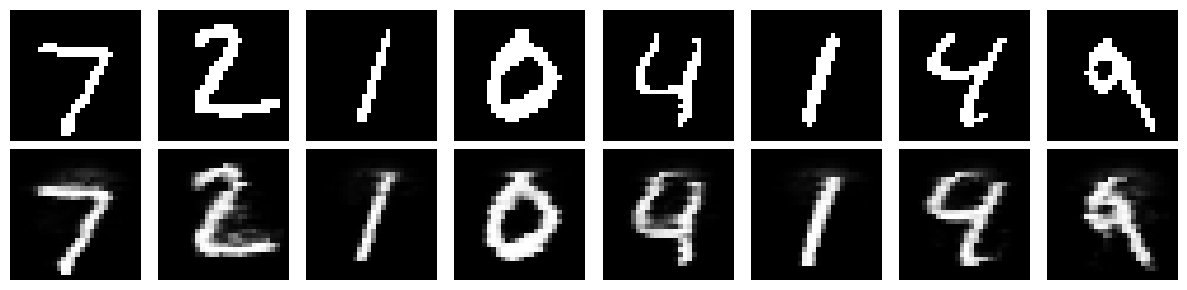

Epoch 24, Loss: 0.1077


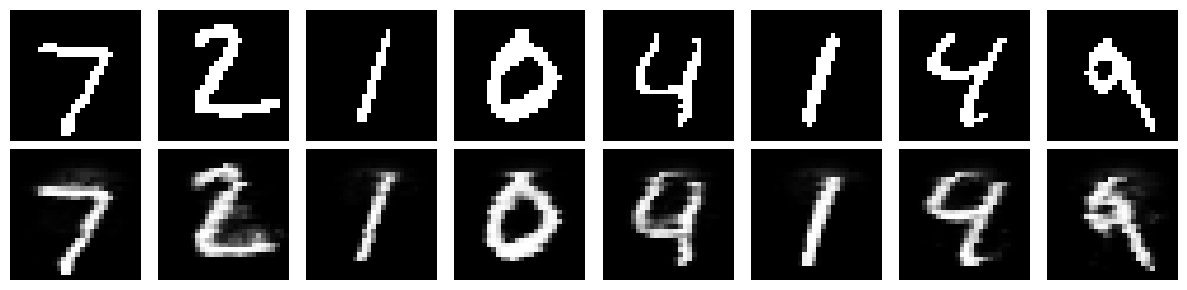

Epoch 25, Loss: 0.1074


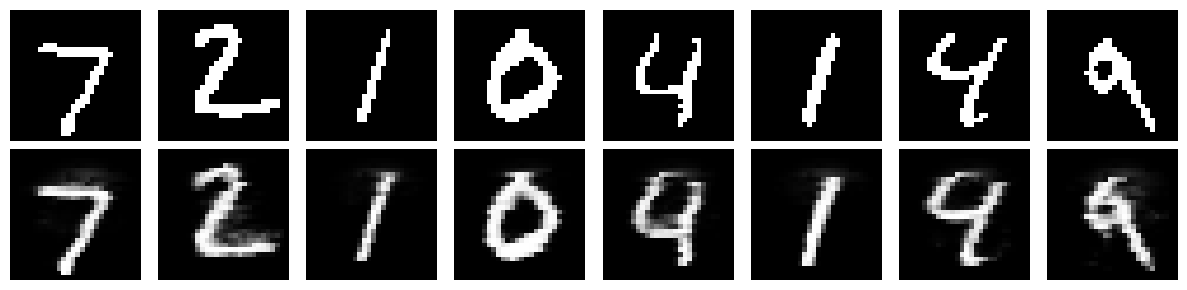

Epoch 26, Loss: 0.1070


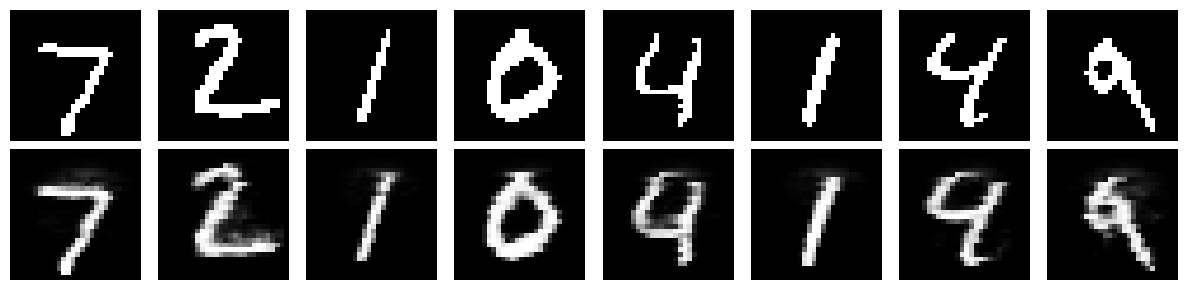

Epoch 27, Loss: 0.1068


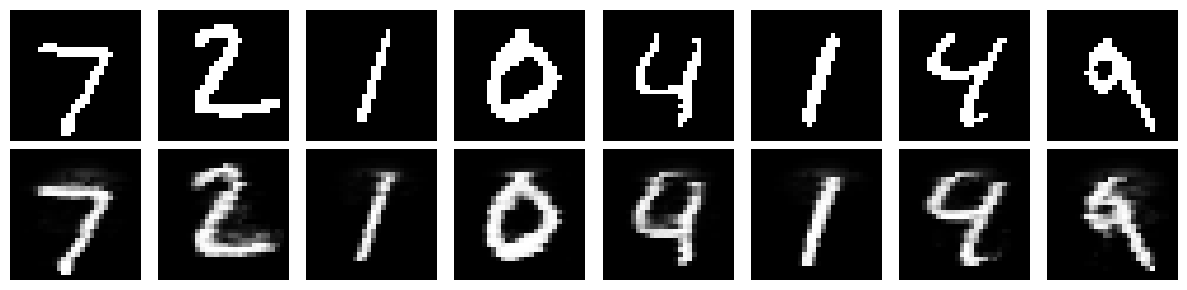

Epoch 28, Loss: 0.1065


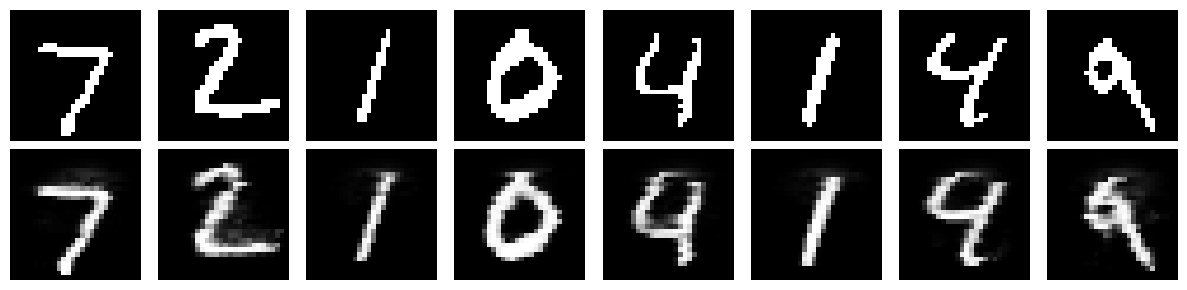

Epoch 29, Loss: 0.1063


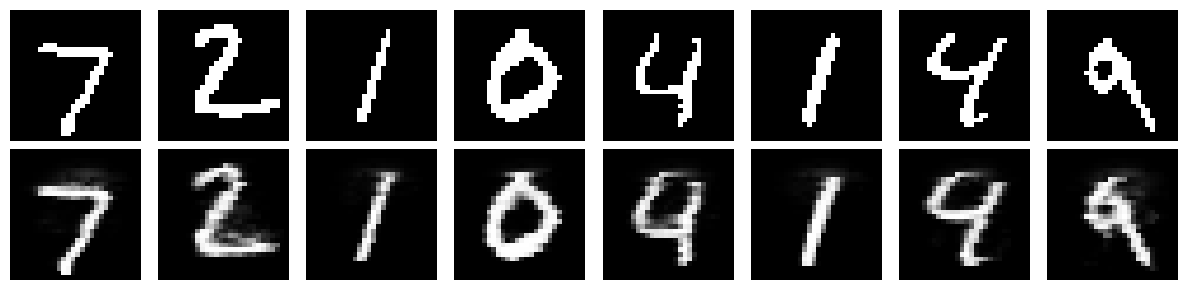

Epoch 30, Loss: 0.1060


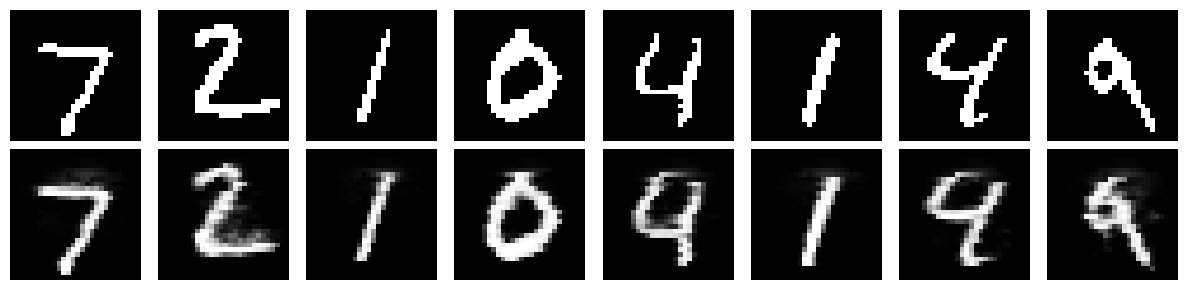

Epoch 31, Loss: 0.1058


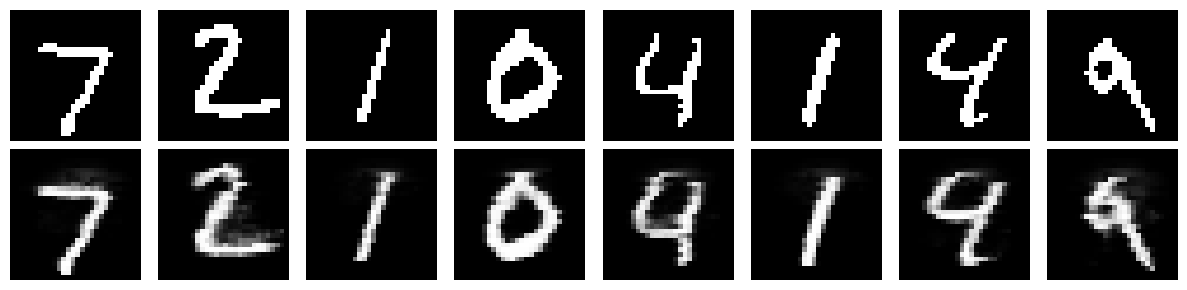

Epoch 32, Loss: 0.1056


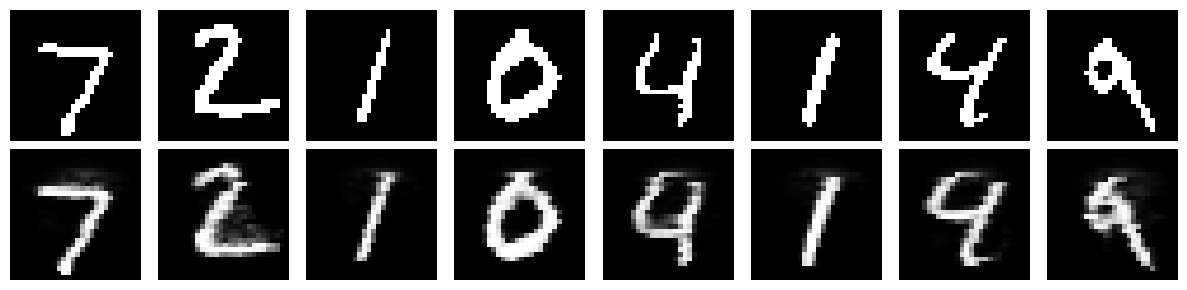

Epoch 33, Loss: 0.1053


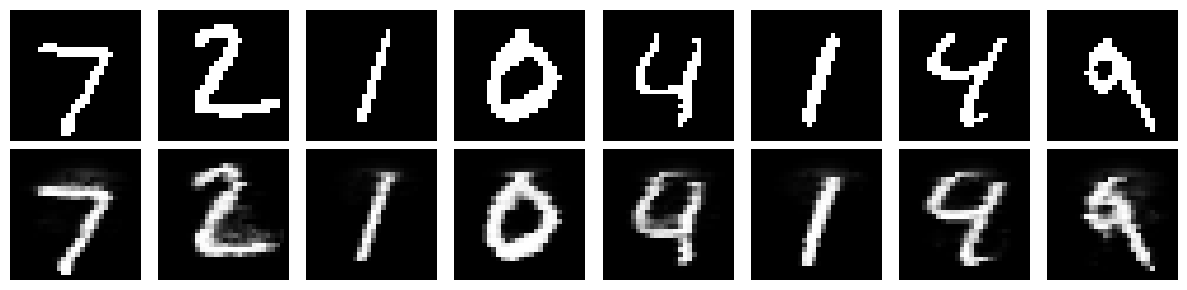

Epoch 34, Loss: 0.1052


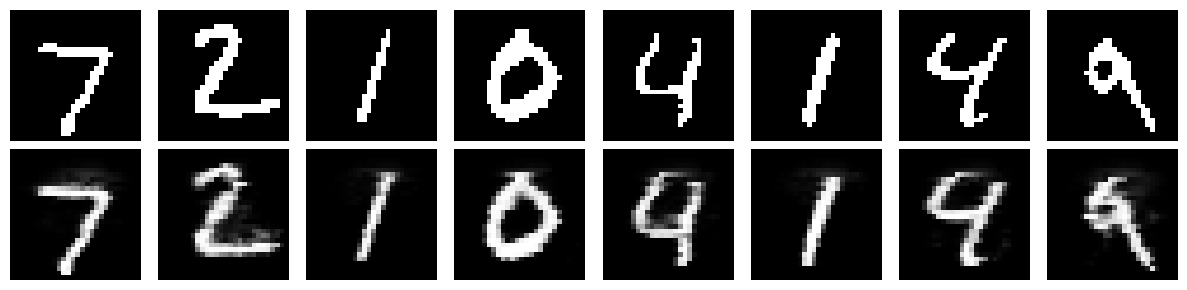

Epoch 35, Loss: 0.1050


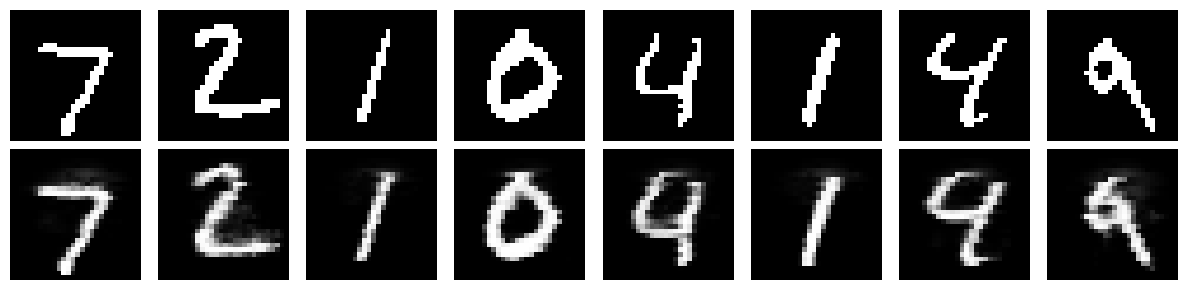

Epoch 36, Loss: 0.1048


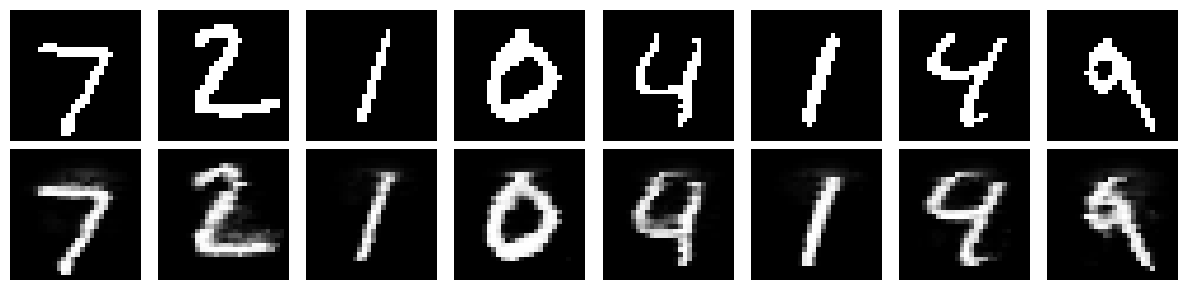

Epoch 37, Loss: 0.1046


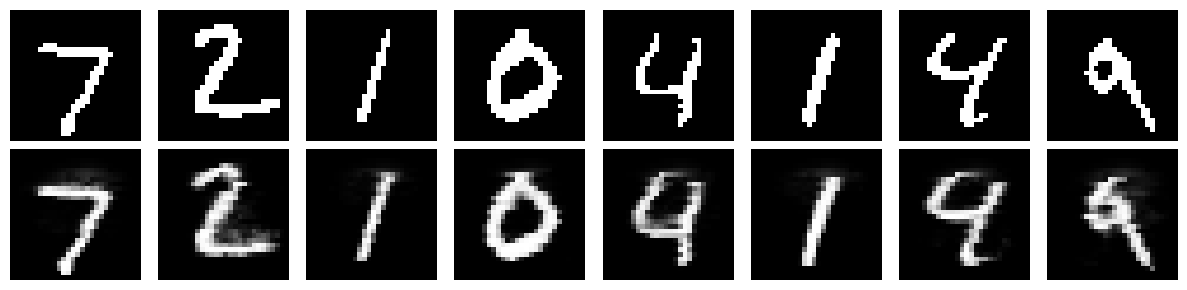

Epoch 38, Loss: 0.1045


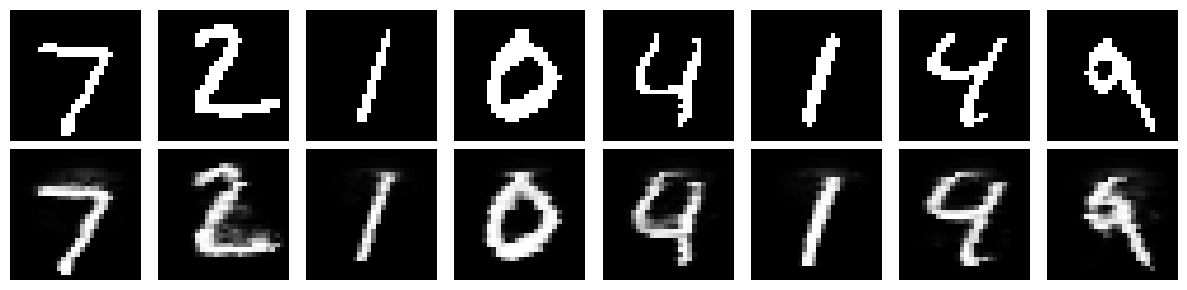

Epoch 39, Loss: 0.1043


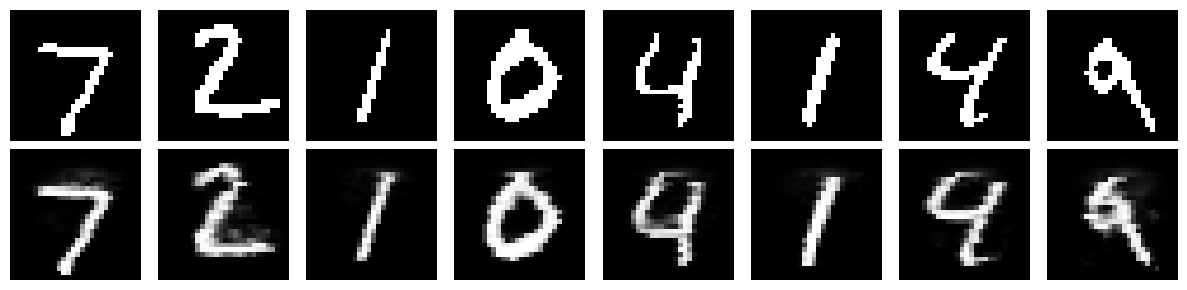

Epoch 40, Loss: 0.1042


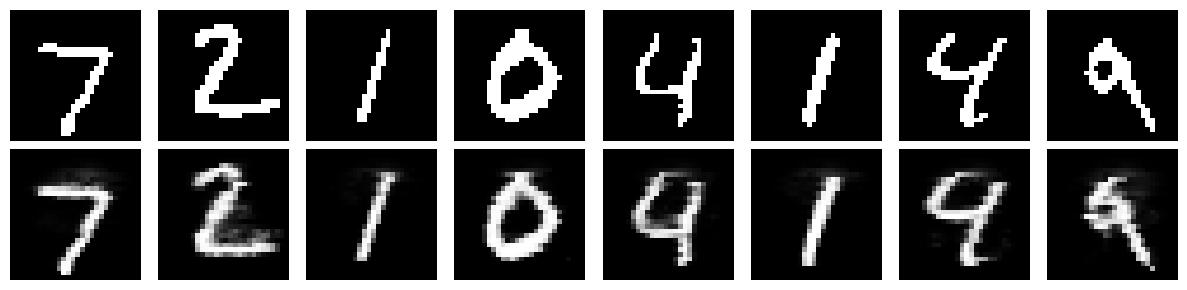

Epoch 41, Loss: 0.1040


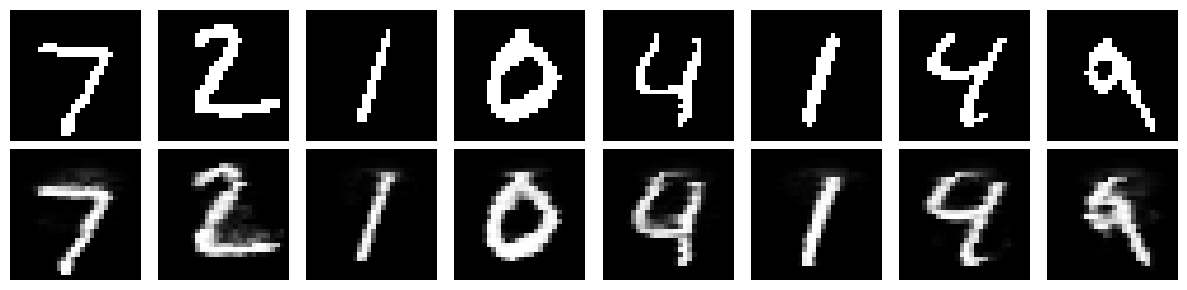

Epoch 42, Loss: 0.1039


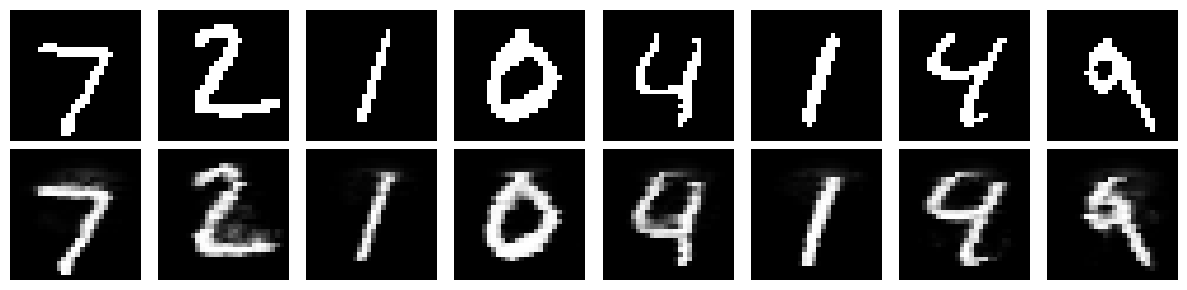

Epoch 43, Loss: 0.1038


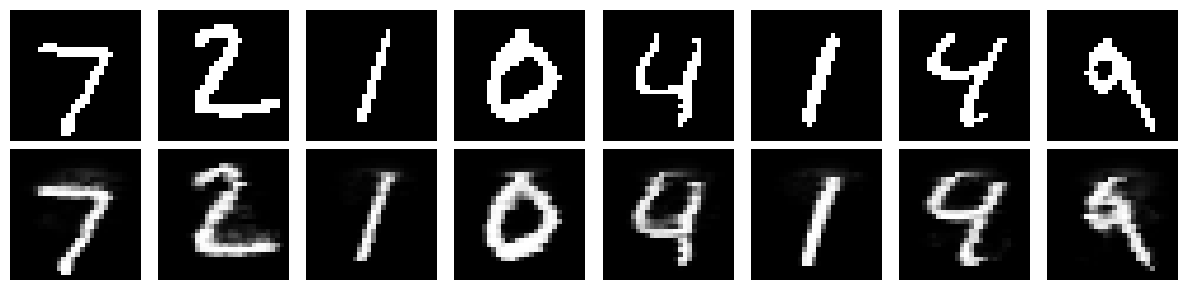

Epoch 44, Loss: 0.1037


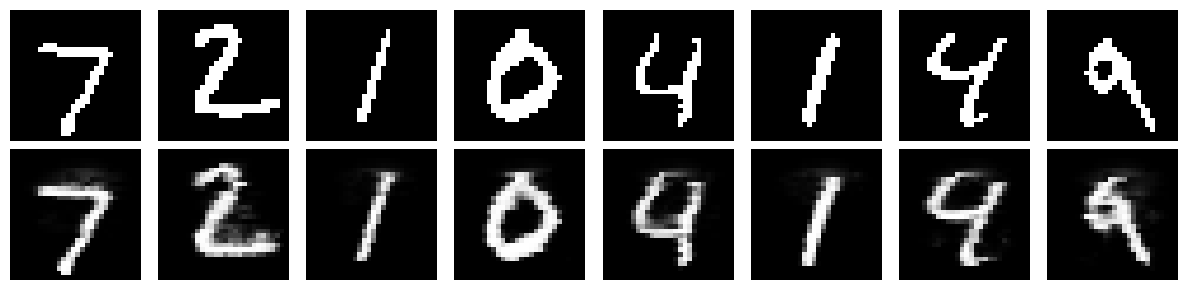

Epoch 45, Loss: 0.1036


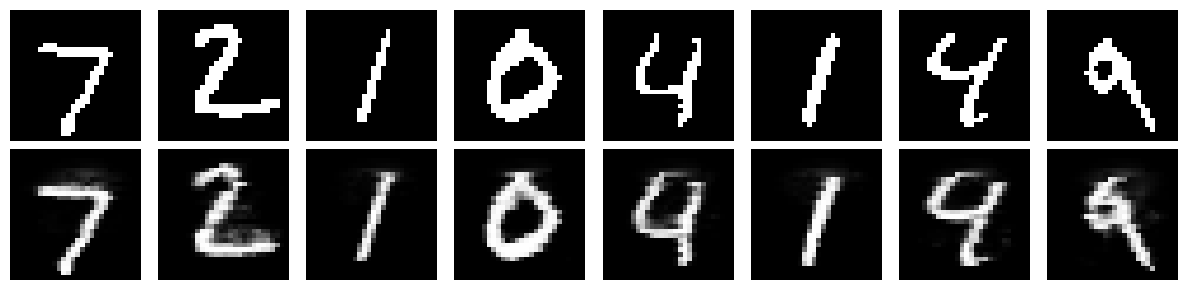

Epoch 46, Loss: 0.1034


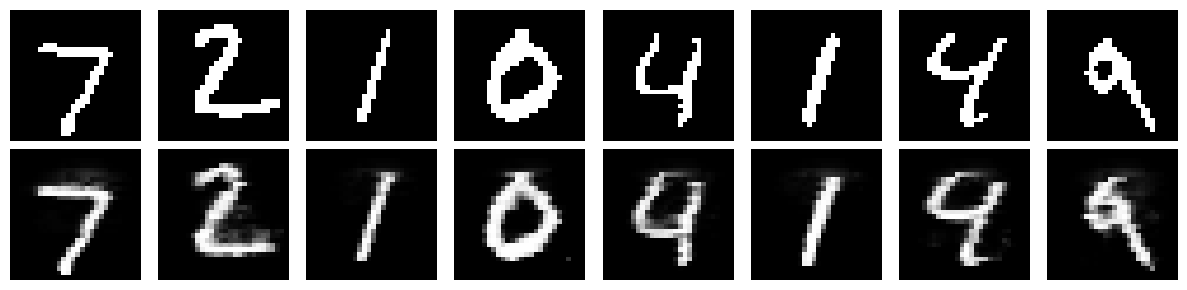

Epoch 47, Loss: 0.1033


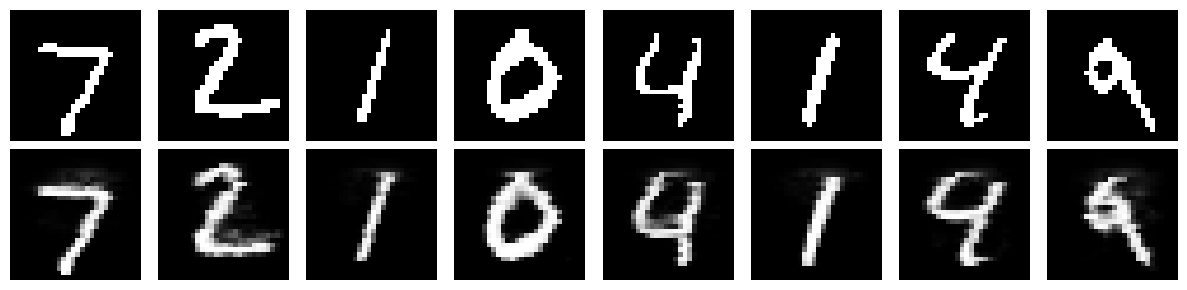

Epoch 48, Loss: 0.1032


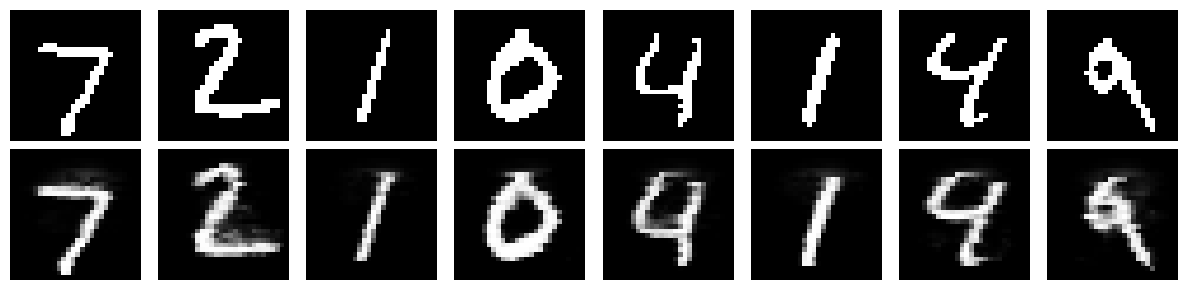

Epoch 49, Loss: 0.1031


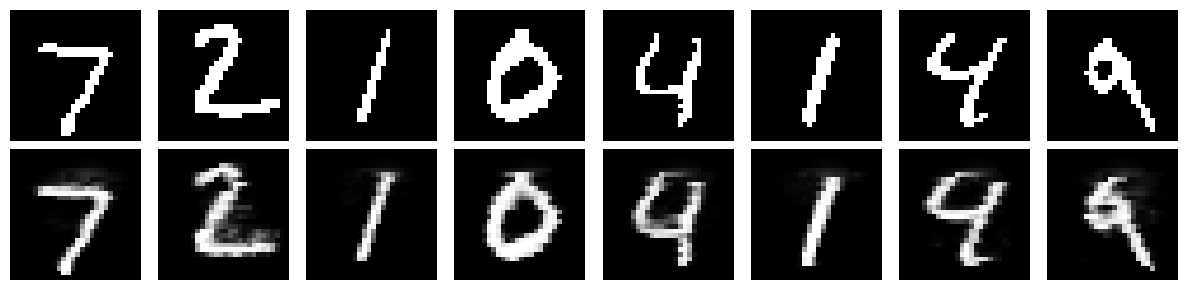

Epoch 50, Loss: 0.1030


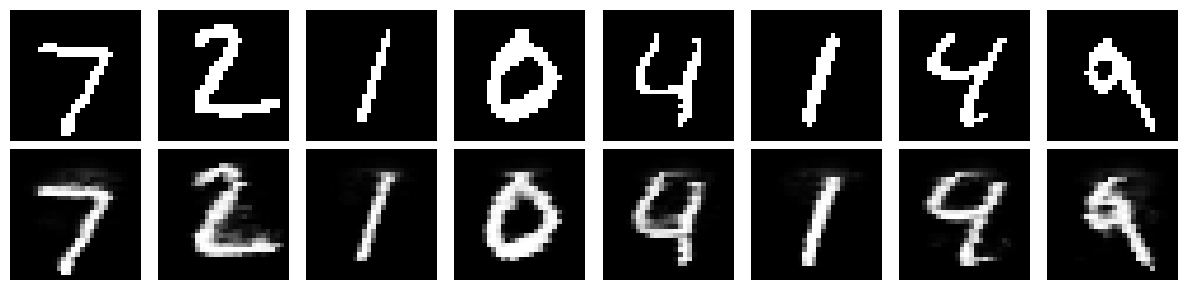

Epoch 51, Loss: 0.1029


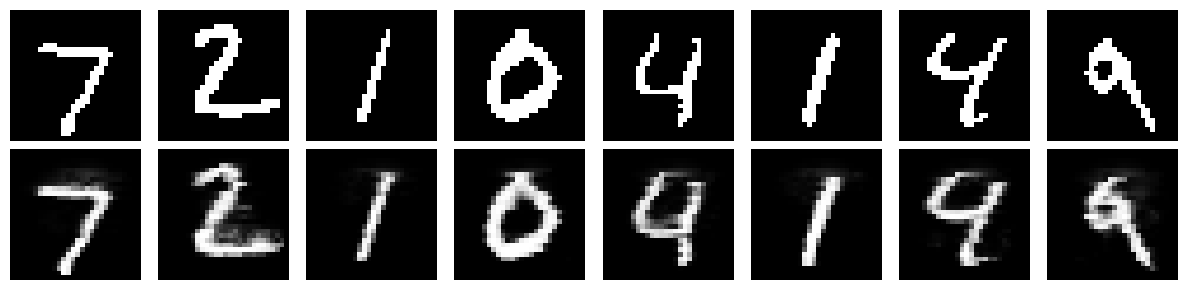

Epoch 52, Loss: 0.1028


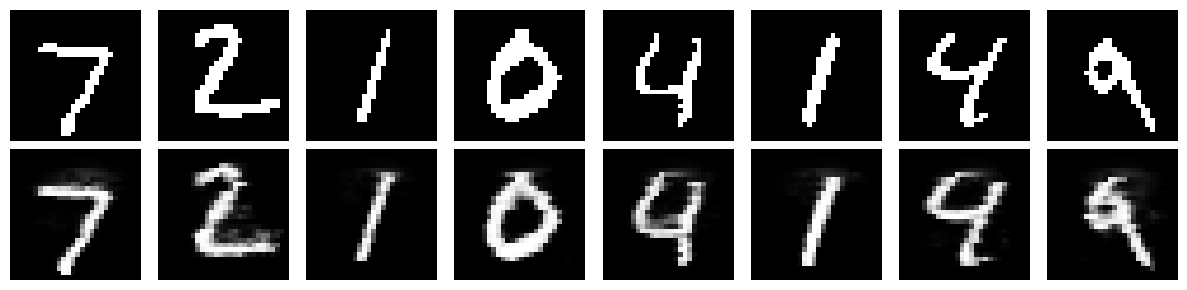

Epoch 53, Loss: 0.1027


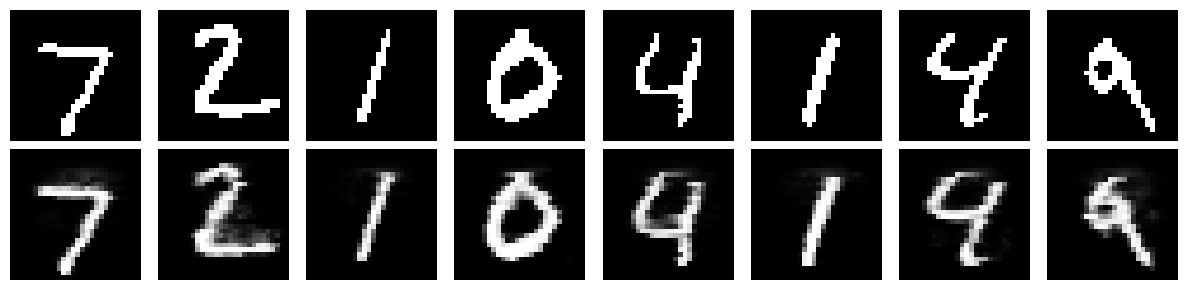

Epoch 54, Loss: 0.1026


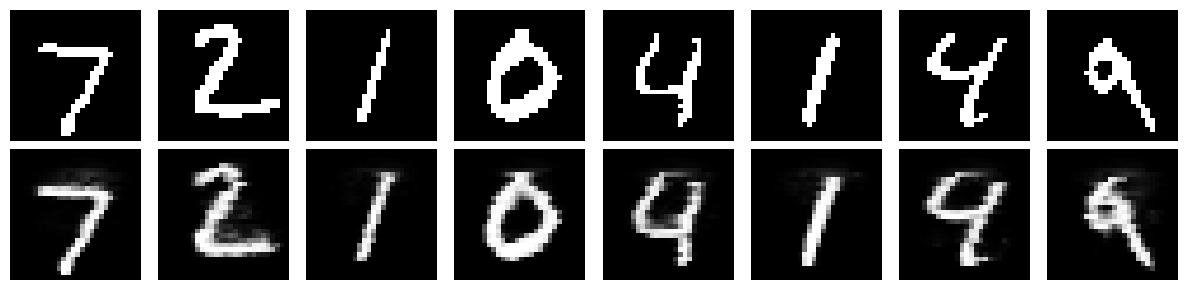

Epoch 55, Loss: 0.1025


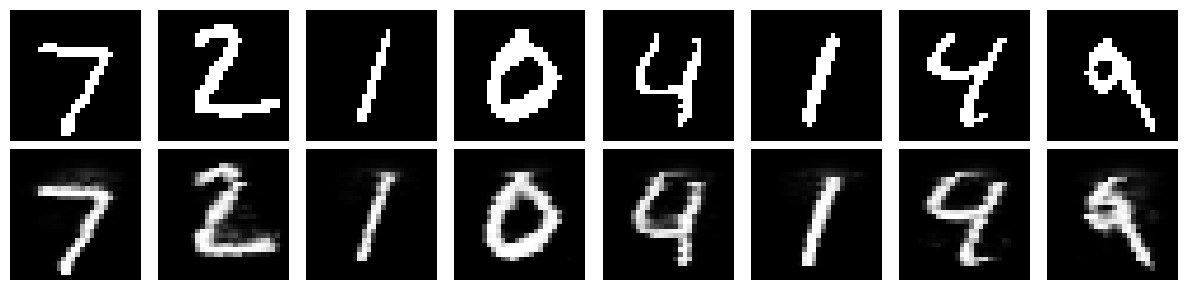

Epoch 56, Loss: 0.1025


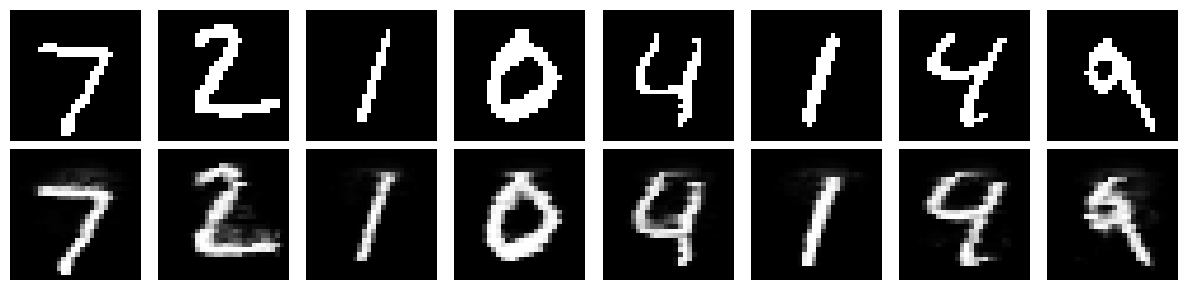

Epoch 57, Loss: 0.1024


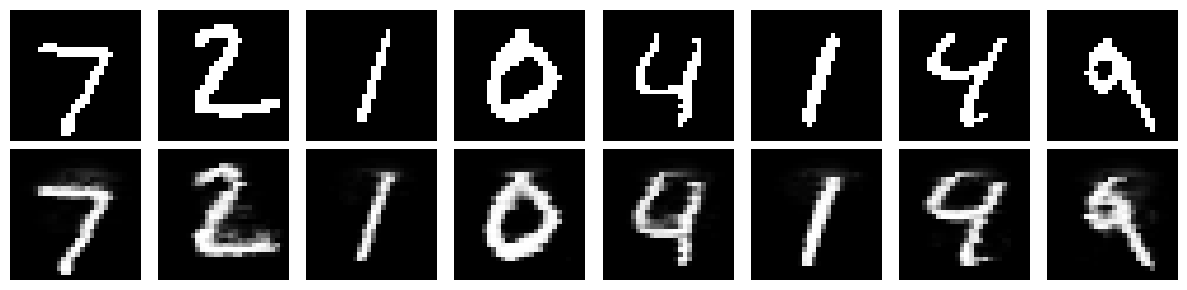

Epoch 58, Loss: 0.1023


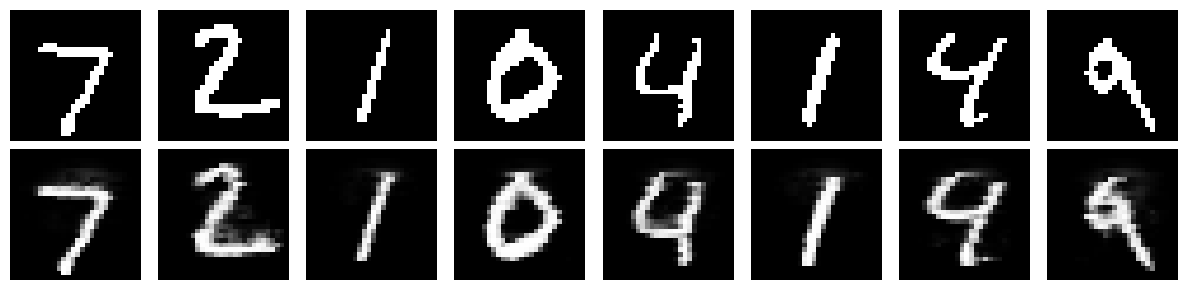

Epoch 59, Loss: 0.1023


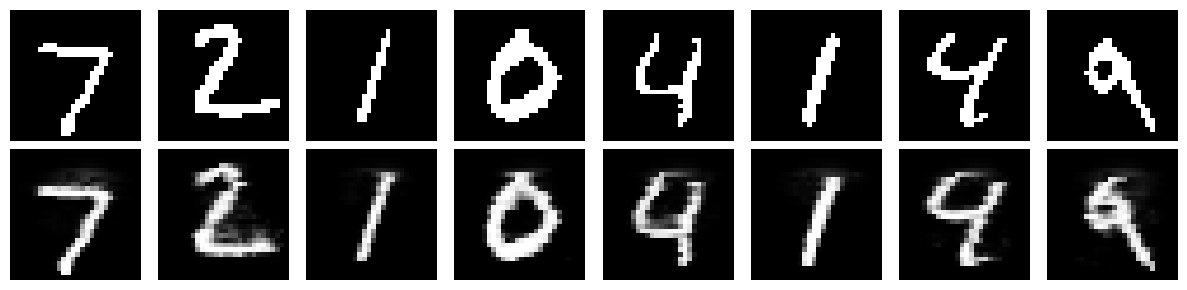

Epoch 60, Loss: 0.1022


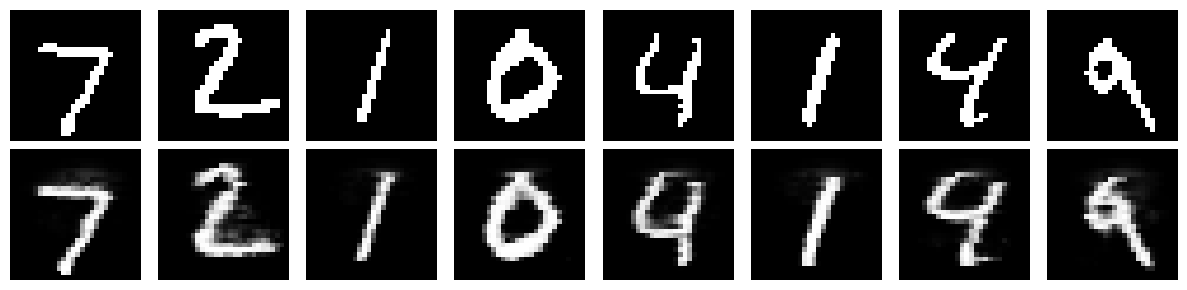

Epoch 61, Loss: 0.1021


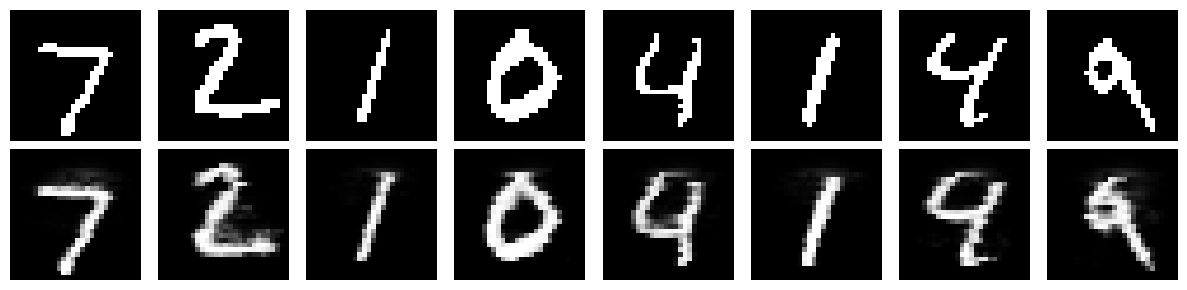

Epoch 62, Loss: 0.1021


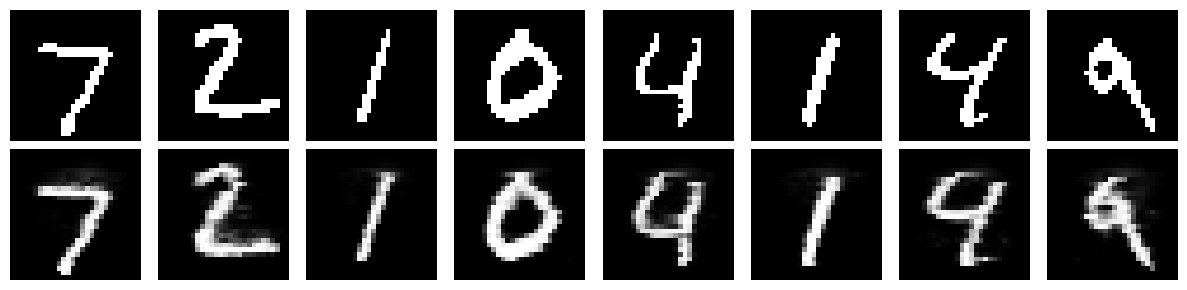

Epoch 63, Loss: 0.1020


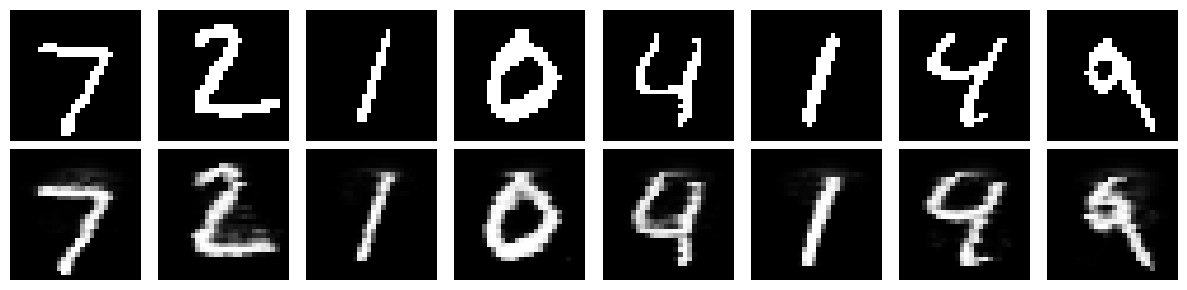

Epoch 64, Loss: 0.1019


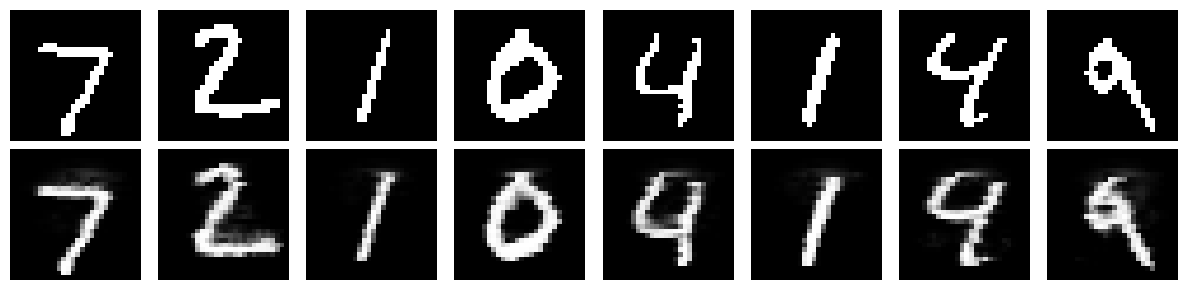

Epoch 65, Loss: 0.1019


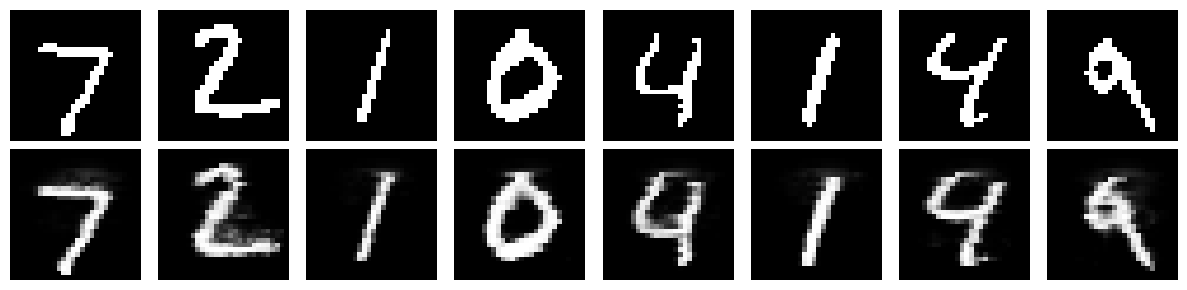

Epoch 66, Loss: 0.1018


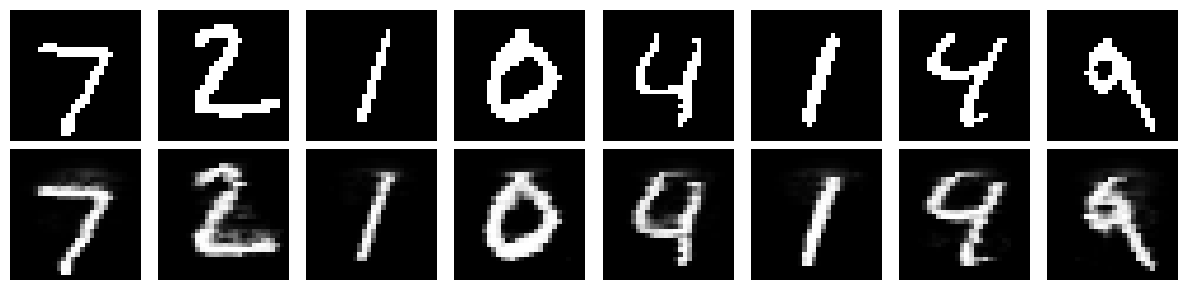

Epoch 67, Loss: 0.1017


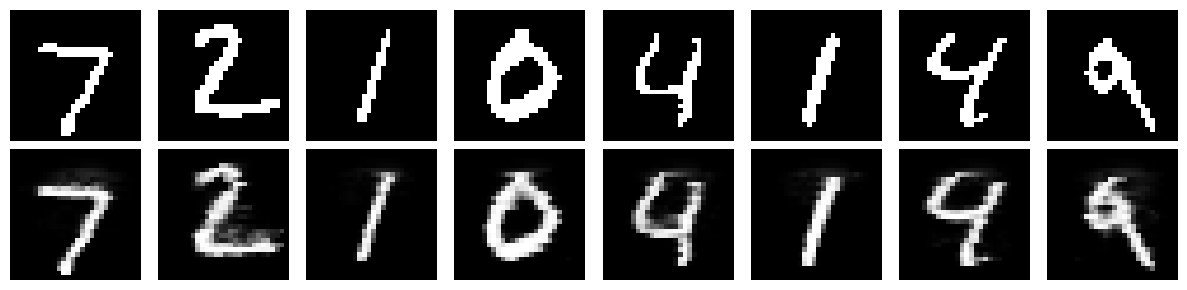

Epoch 68, Loss: 0.1017


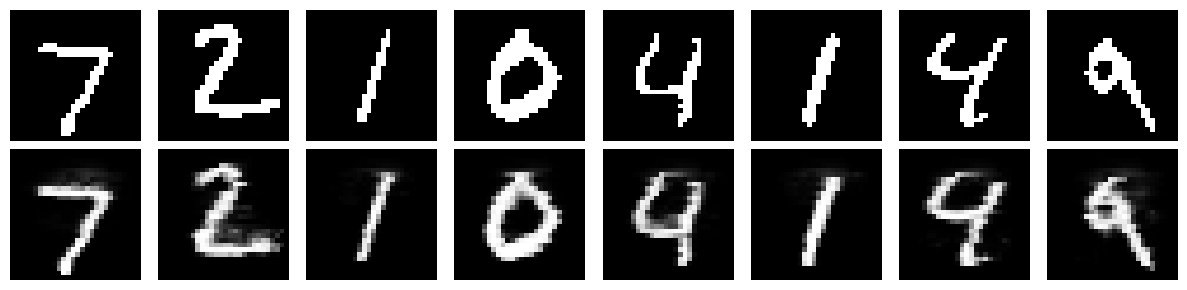

Epoch 69, Loss: 0.1016


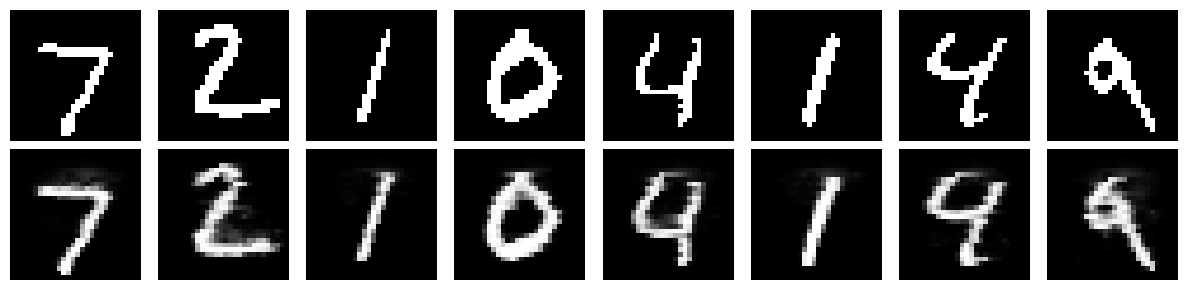

Epoch 70, Loss: 0.1016


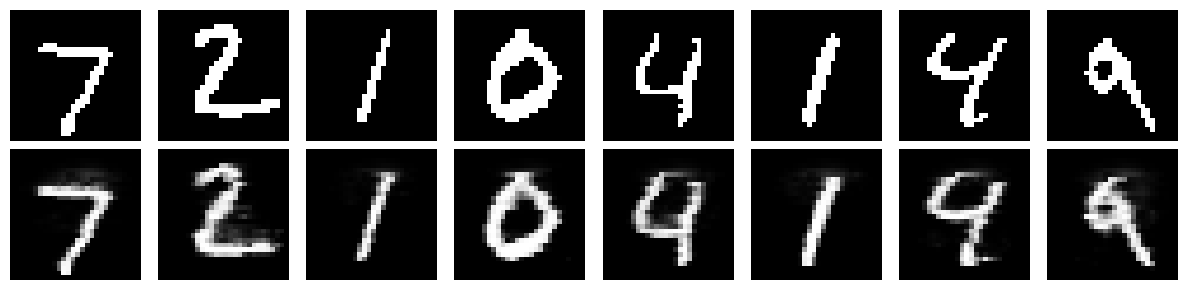

Epoch 71, Loss: 0.1015


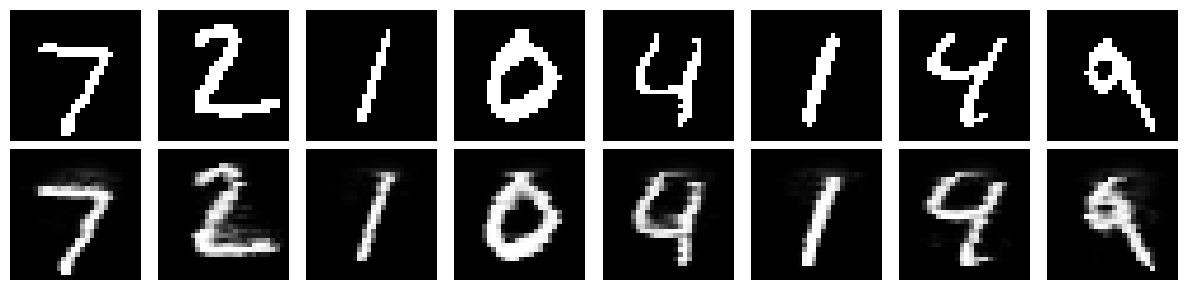

Epoch 72, Loss: 0.1015


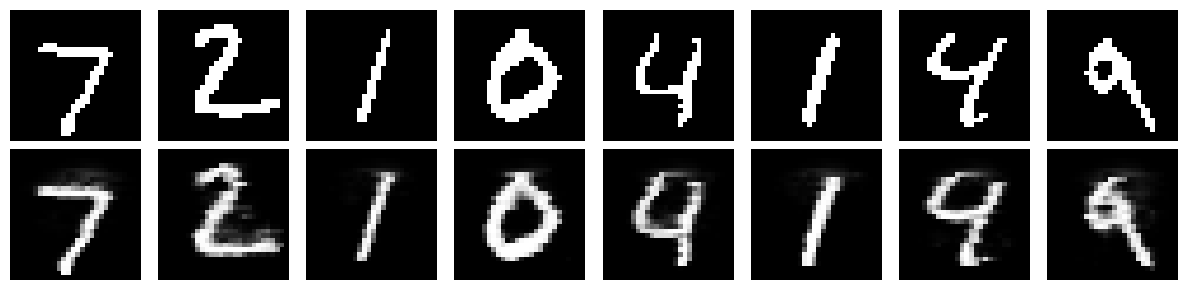

Epoch 73, Loss: 0.1014


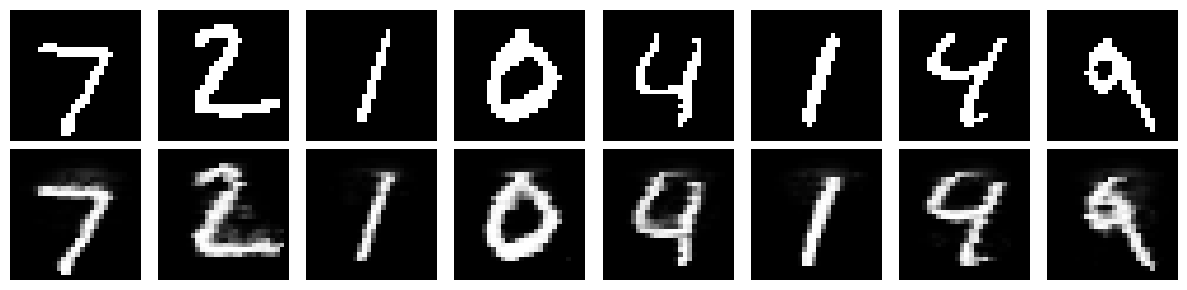

Epoch 74, Loss: 0.1014


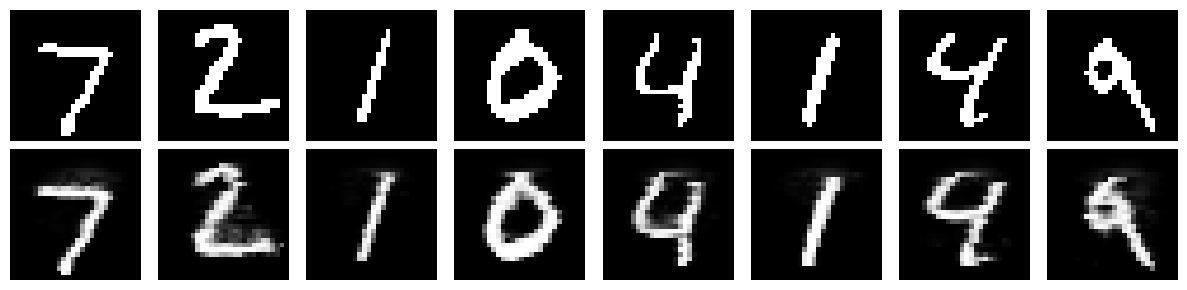

Epoch 75, Loss: 0.1013


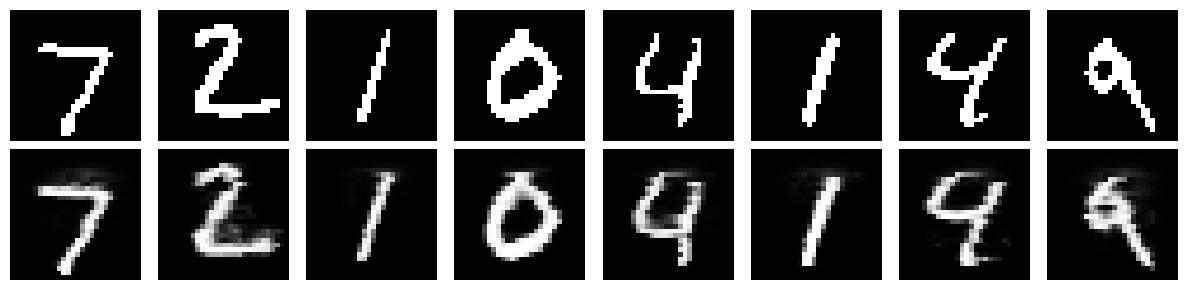

Epoch 76, Loss: 0.1013


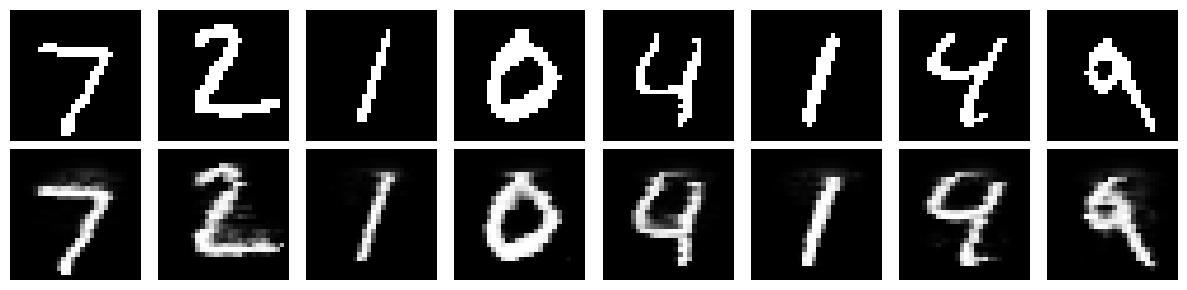

Epoch 77, Loss: 0.1013


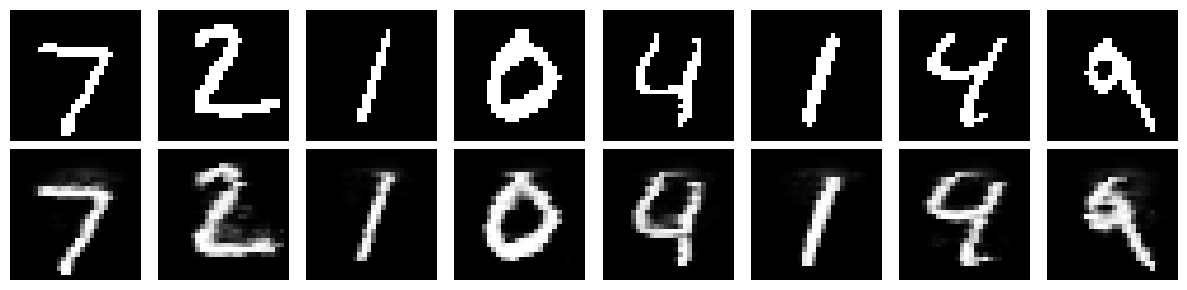

Epoch 78, Loss: 0.1012


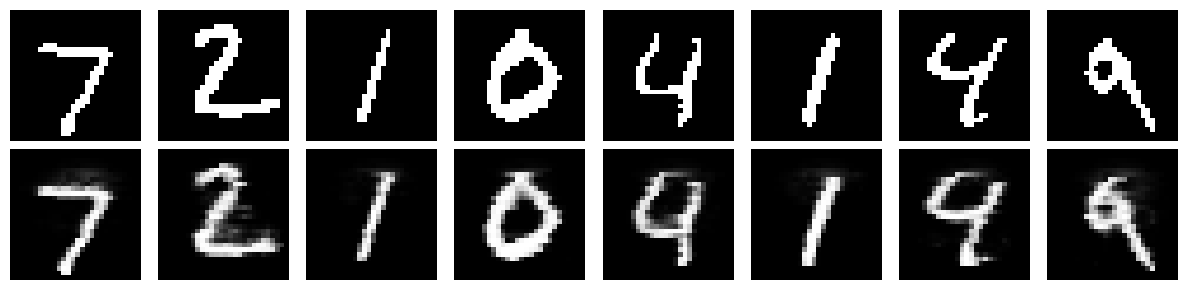

Epoch 79, Loss: 0.1011


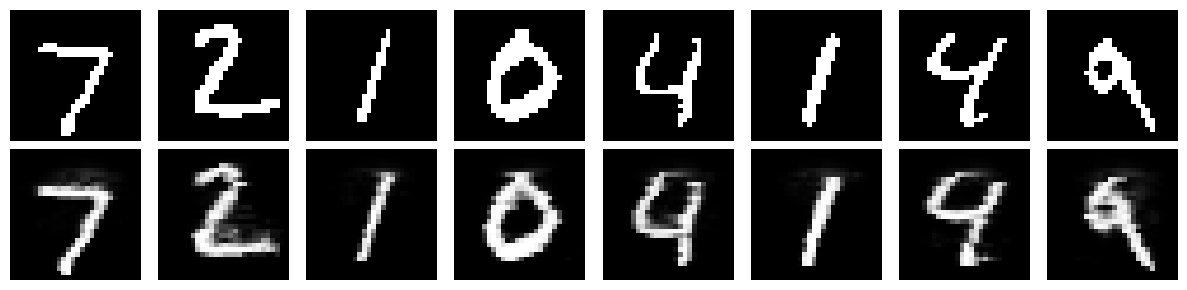

Epoch 80, Loss: 0.1011


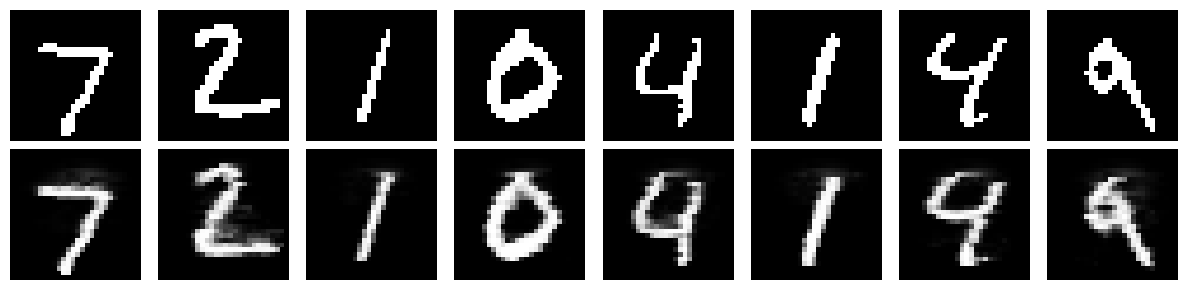

Epoch 81, Loss: 0.1011


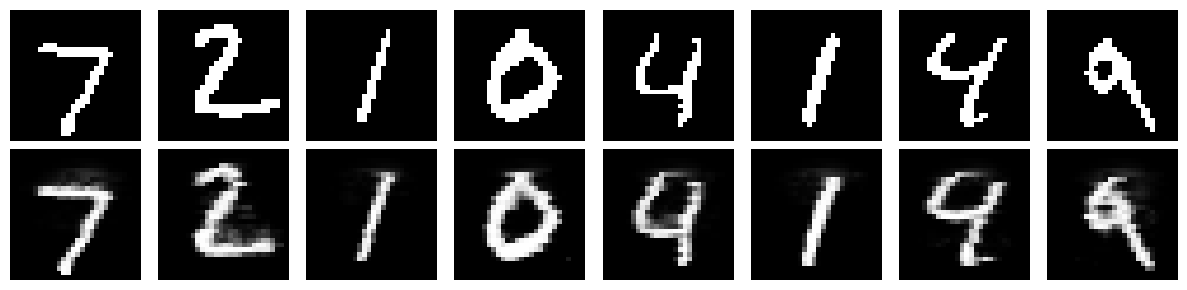

Epoch 82, Loss: 0.1010


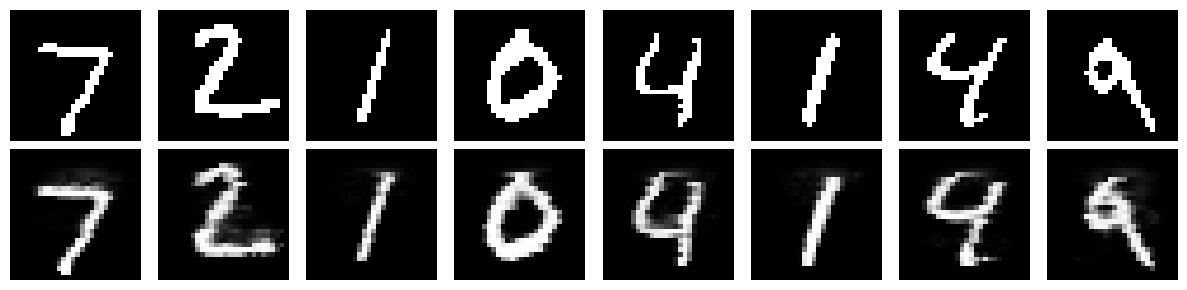

Epoch 83, Loss: 0.1010


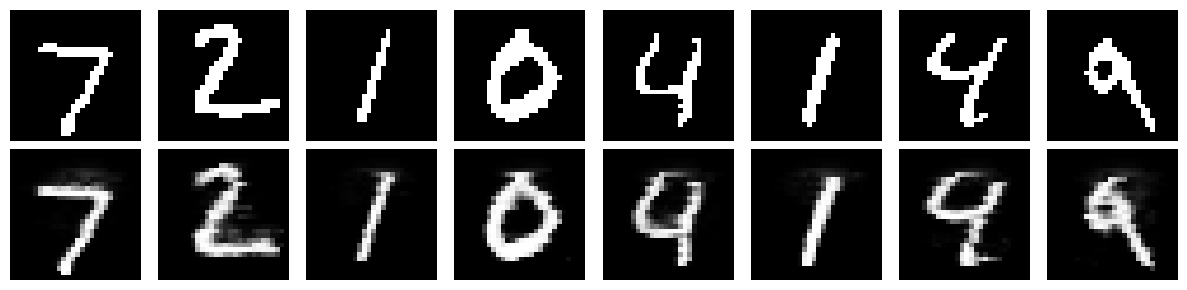

Epoch 84, Loss: 0.1009


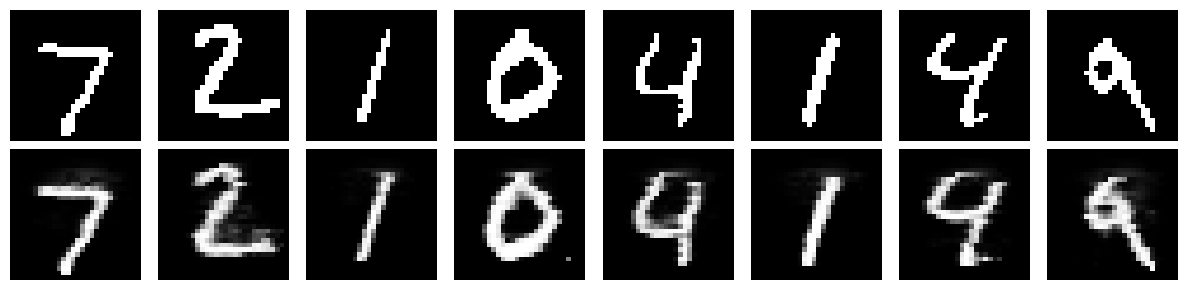

Epoch 85, Loss: 0.1009


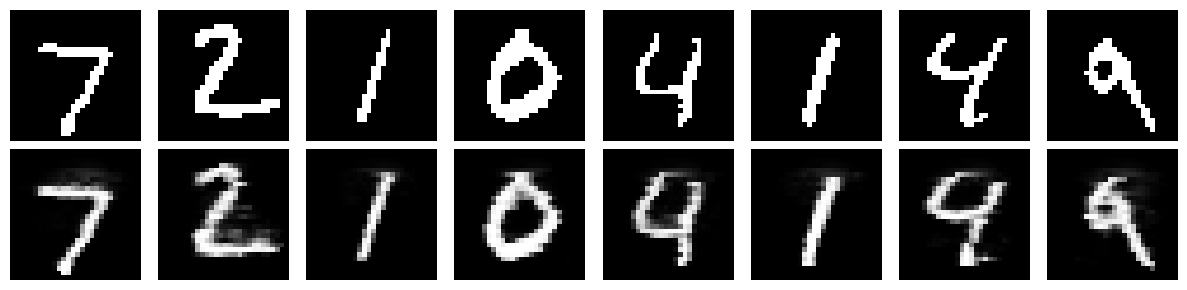

Epoch 86, Loss: 0.1009


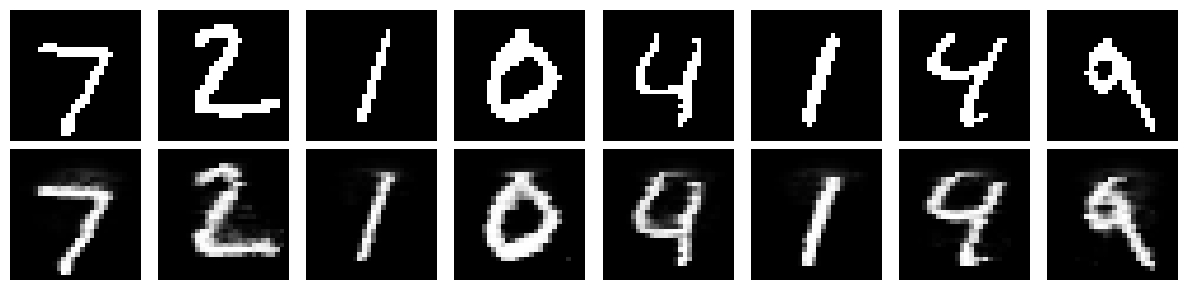

Epoch 87, Loss: 0.1008


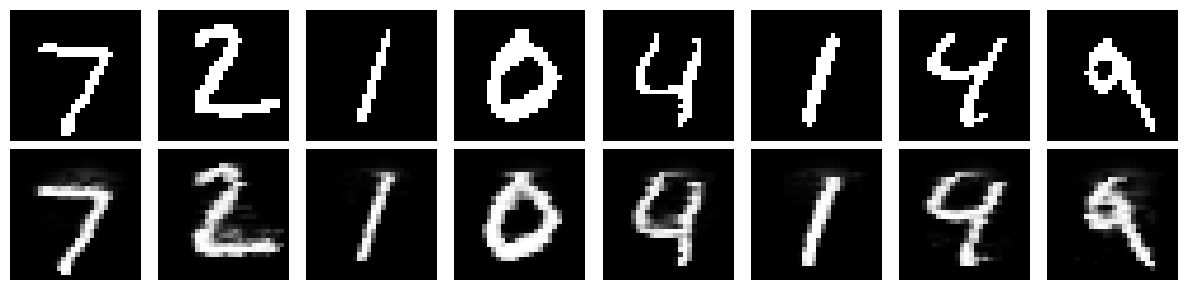

Epoch 88, Loss: 0.1008


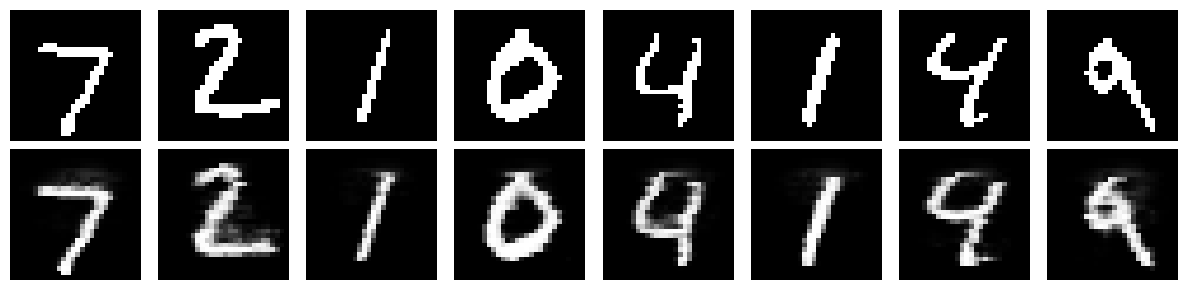

Epoch 89, Loss: 0.1007


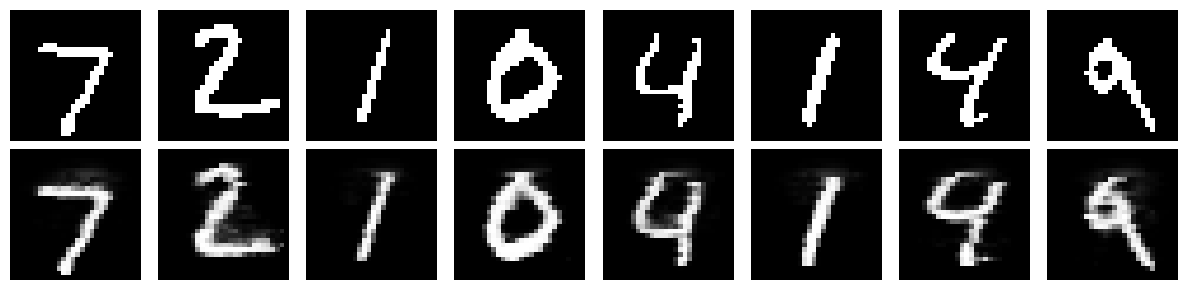

Epoch 90, Loss: 0.1007


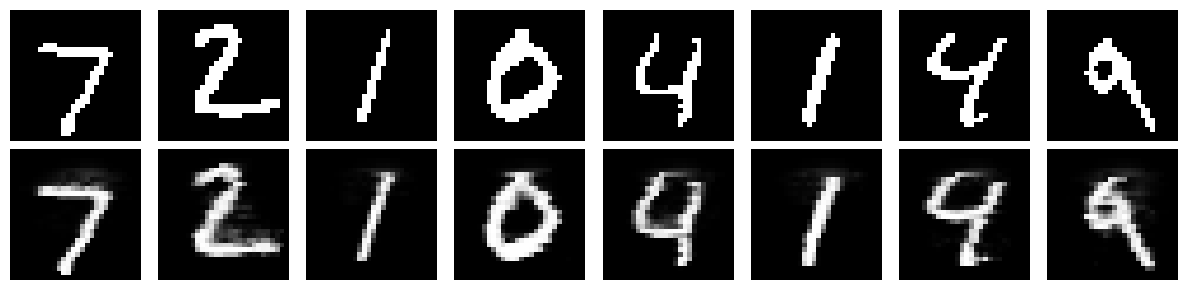

Epoch 91, Loss: 0.1007


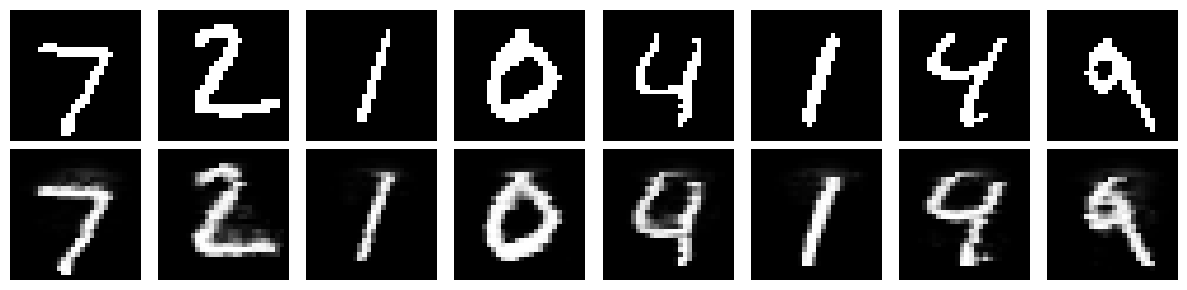

Epoch 92, Loss: 0.1007


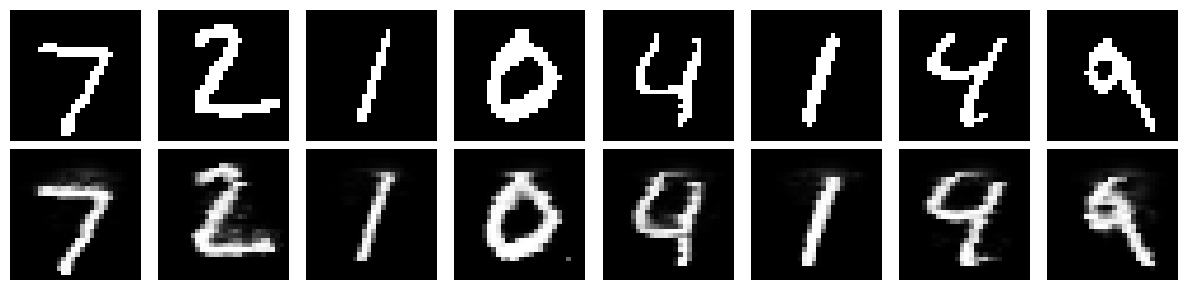

Epoch 93, Loss: 0.1006


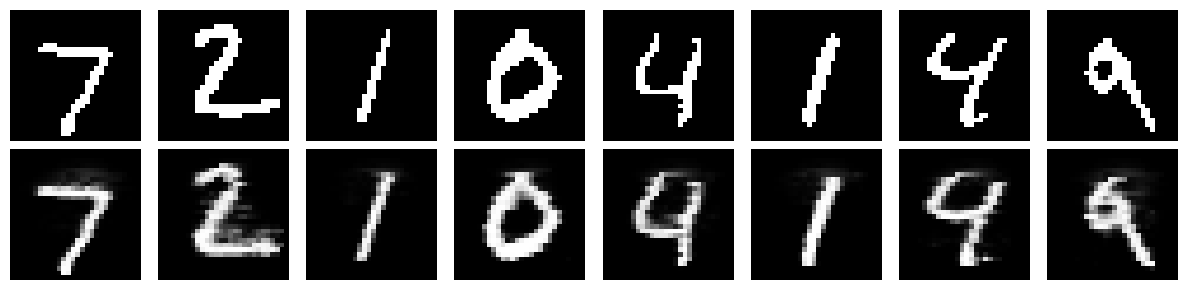

Epoch 94, Loss: 0.1006


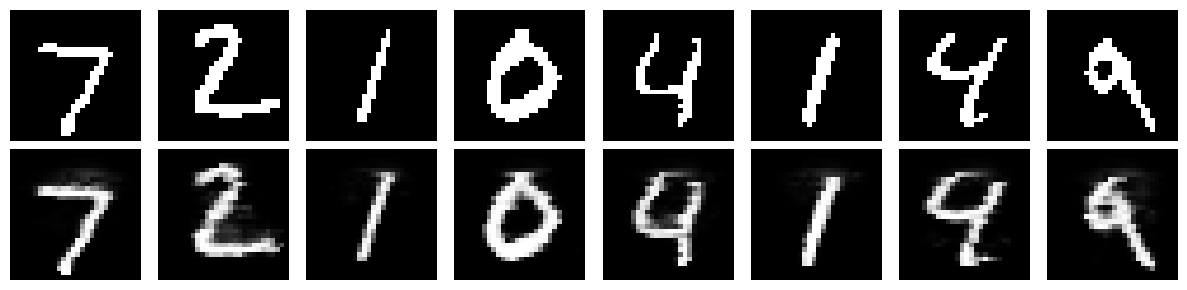

Epoch 95, Loss: 0.1006


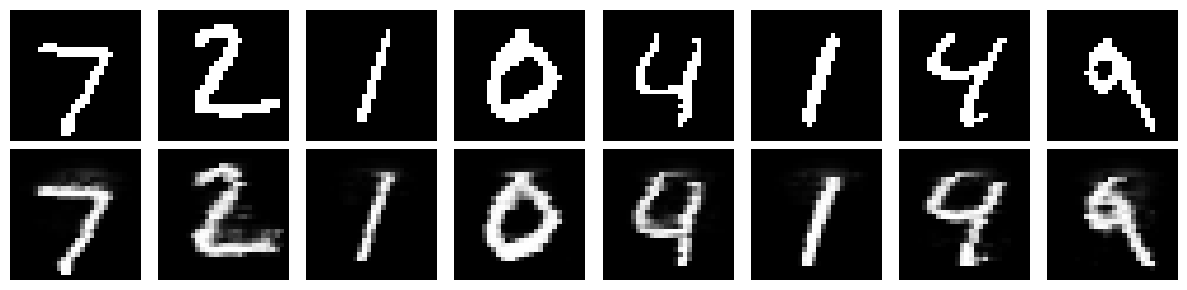

Epoch 96, Loss: 0.1005


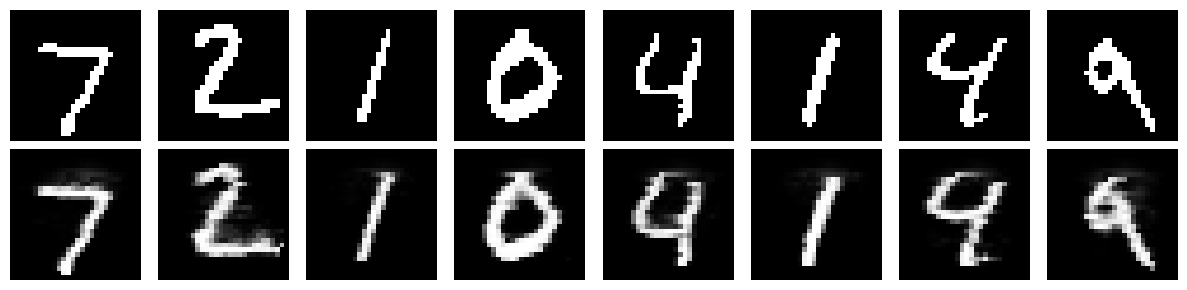

Epoch 97, Loss: 0.1005


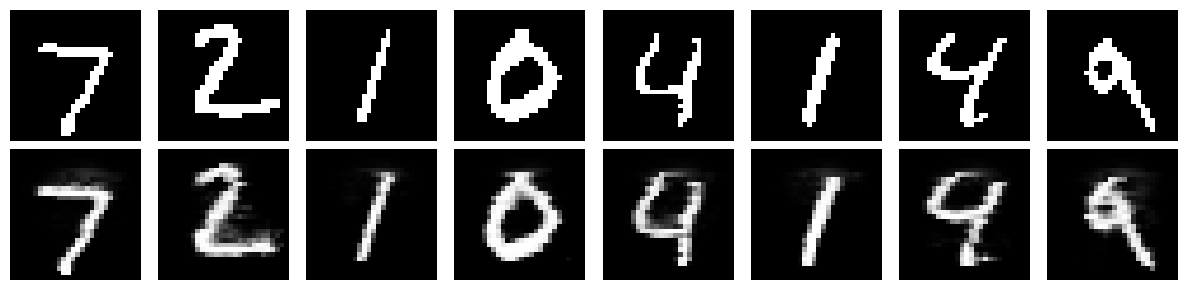

Epoch 98, Loss: 0.1005


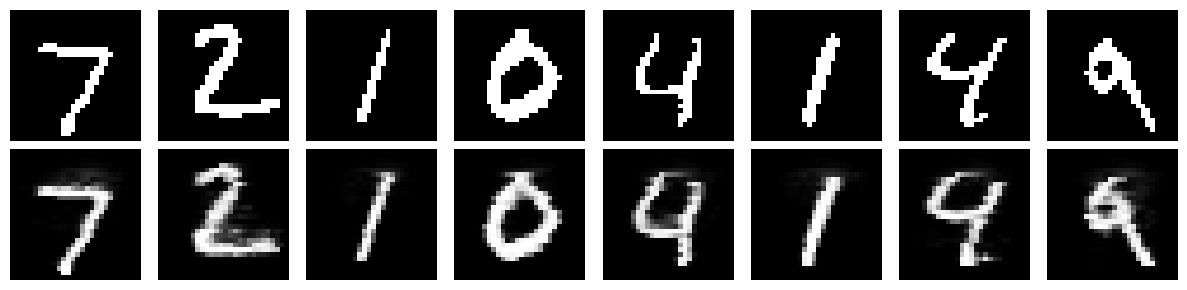

Epoch 99, Loss: 0.1004


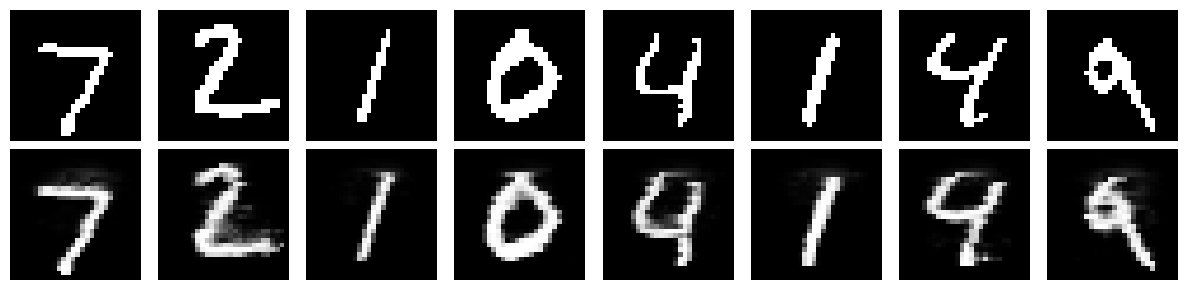

Epoch 100, Loss: 0.1004


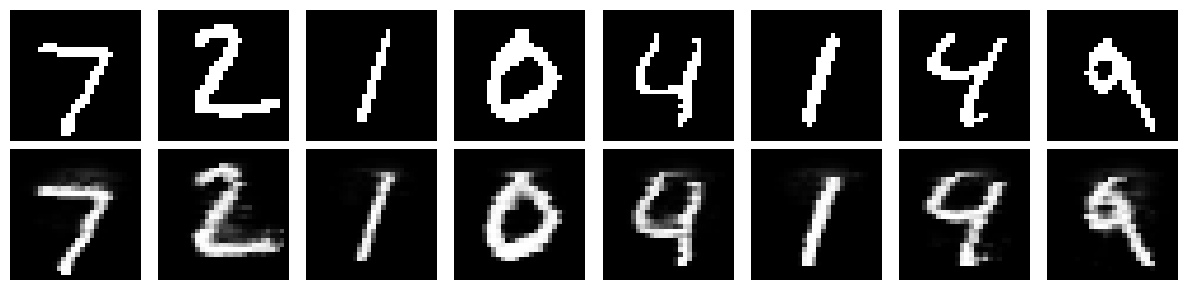

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MADE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def loss_fn(logits, x):
    return F.binary_cross_entropy_with_logits(logits, x, reduction="mean")

for epoch in range(100):  # Start with 10 epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        x, _ = batch
        x = x.view(-1, 784).to(device)
        logits = model(x)
        loss = loss_fn(logits, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

    # ✅ Visualize reconstructions
    reconstruct_and_plot(model, test_loader)

In [ ]:
torch.save(model.state_dict(), "made_mnist.pth")

In [ ]:
import torch
import matplotlib.pyplot as plt


@torch.no_grad()
def sample(model, n_samples=16):
    model.eval()
    samples = torch.zeros(n_samples, 784).to(device)
    for i in range(784):
        logits = model(samples)
        probs = torch.sigmoid(logits[:, i])
        samples[:, i] = torch.bernoulli(probs)
    return samples.view(n_samples, 1, 28, 28).cpu()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(samples):
    samples = samples > 0.8  # Convert to binary
    # Assuming samples is a tensor with shape (n_samples, input_size)
    n_samples = samples.size(0)
    samples = samples.view(n_samples, 28, 28).cpu().data.numpy()  # Reshape to 28x28

    # Plotting the samples
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    axes = axes.flatten()
    for i in range(n_samples):
        axes[i].imshow(samples[i], cmap='gray',interpolation='nearest')
        axes[i].axis('off')
    plt.show()


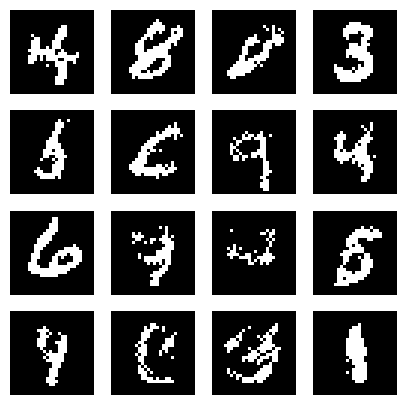

In [ ]:
model = MADE().to(device)
model.load_state_dict(torch.load("made_mnist.pth"))
model.eval()

samples = sample(model, n_samples=16)
plot_samples(samples)

